In [14]:
import glob
import itertools
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch as tc
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import numba
from tqdm import tqdm
from tqdm import trange

warnings.filterwarnings(action='ignore')


In [15]:
def get_dataframe_from_dir(path, ext, ignore_idx=False, save_file=False):
    df = pd.DataFrame()
    if ext != 'csv':
        return df
    
    csv_files = glob.glob(path + f"/*.{ext}")
    df_list = (pd.read_csv(file) for file in csv_files)
    get_next = peek(df_list)

    if get_next is None:
        print("***** empty dataframe *****")
        return df
    
    df = pd.concat(df_list, ignore_index=ignore_idx)
    if save_file:
        df.to_csv('merged.csv')
    if 'time' in df.columns:
        df.set_index("time", drop=True, append=False, inplace=True)
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    else:
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    
    return df

In [16]:
def peek(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first, itertools.chain([first], iterable)

In [17]:
def build_model(n_est=100, crt="squared_error", max_depth=None, max_leaf_nodes=None, bs=True, oob_score=False, n_jobs=None, rs=None, max_samples=None):
    model = RandomForestRegressor(
        n_estimators=n_est,
        criterion=crt,
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        bootstrap=bs,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=rs,
        max_samples=max_samples
    )
    return model


In [18]:
df = get_dataframe_from_dir("../data/xaiops_was_metrics/214(04.01~07.10)/", "csv", save_file=True)
# df = df.sample(frac=0.01)

# remove low variance column
for column in df.columns:
    if df[column].mean() == 0:
        df.drop(columns=[column], inplace=True)

# remove rows having NaN value
df.dropna(axis=0, inplace=True)

# sort index
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143908 entries, 2022-04-02 00:00:00 to 2022-07-10 23:59:00
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   active_db_conn_count  143908 non-null  float64
 1   active_tx_count       143908 non-null  float64
 2   active_users          143908 non-null  float64
 3   call_count            143908 non-null  float64
 4   cpu_time              143908 non-null  float64
 5   cpu_usage             143908 non-null  float64
 6   db_sessions           143908 non-null  float64
 7   fetch_count           143908 non-null  float64
 8   fgc                   143908 non-null  float64
 9   fgct                  143908 non-null  float64
 10  file_count            143908 non-null  float64
 11  gc_count              143908 non-null  float64
 12  gc_time               143908 non-null  float64
 13  heap_usage            143908 non-null  float64
 14  jvm_free_heap         1439

In [19]:
df.describe()

,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct
count,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,...,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000,143908.000000
mean,0.347314,6.099119,1.121999,10.227788,2.682618,1.713626,8.978567,28.616352,0.008766,1.225434,...,63.980593,198.339632,63.980593,690.252175,1.030858,9.380656,143.263386,9.971841,1.022093,8.155223
std,0.855377,35.362698,0.432401,8.802533,3.074359,1.481491,0.332398,25.884574,0.019016,2.671885,...,56.847447,796.714637,56.847448,1230.470690,0.670263,6.834281,42.858960,8.750817,0.663375,5.424257
min,0.000000,0.000000,0.000000,0.000000,0.144000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.600000,0.000000,0.000000,0.000000
25%,0.000000,0.150000,0.800000,2.650000,0.492500,0.300000,9.000000,6.100000,0.000000,0.000000,...,13.650000,29.203600,13.650000,83.850000,0.350000,2.450000,119.850000,2.449900,0.300000,2.350000
50%,0.100000,0.550000,1.200000,8.950000,0.926000,1.600000,9.000000,24.450000,0.000000,0.000000,...,55.150000,35.807800,55.150000,289.500000,1.150000,10.050000,141.950000,8.666600,1.150000,9.400000
75%,0.300000,1.950000,1.450000,14.900000,4.601225,2.650000,9.000000,42.100000,0.000000,0.000000,...,94.650000,64.223875,94.650000,755.000000,1.600000,14.050000,154.800000,14.600000,1.600000,13.000000
max,8.700000,300.000000,2.100000,57.100000,14.845000,11.550000,9.800000,217.950000,0.166667,24.333333,...,315.250000,141017.833300,315.250000,79966.600000,14.833300,154.500000,406.000000,48.699900,14.666667,130.166667


In [20]:
df.head(5)

,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,fgct,...,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct
time,,,,,,,,,,,,,,,,,,,,,
2022-04-02 00:00:00,0.10,1.10,0.20,0.55,0.2020,0.0,9.0,0.2,0.0,0.0,...,0.2,187.8437,0.2,288.20,0.05,0.15,190.0,0.5333,0.05,0.15
2022-04-02 00:01:00,0.05,1.10,0.10,0.15,0.1800,0.0,9.0,0.1,0.0,0.0,...,0.1,421.0000,0.1,166.55,0.05,0.15,190.0,0.1333,0.05,0.15
2022-04-02 00:02:00,0.05,1.05,0.15,0.40,0.1969,0.0,9.0,0.2,0.0,0.0,...,0.2,214.3636,0.2,225.90,0.05,0.20,190.0,0.3666,0.05,0.20
2022-04-02 00:03:00,0.00,1.00,0.05,0.40,0.1714,0.0,9.0,0.1,0.0,0.0,...,0.1,88.3750,0.1,103.25,0.05,0.40,189.4,0.3999,0.05,0.40
2022-04-02 00:04:00,0.05,1.05,0.15,0.55,0.1920,0.0,9.0,0.2,0.0,0.0,...,0.2,107.6250,0.2,168.35,0.05,0.20,181.3,0.5333,0.05,0.20


In [21]:
df.reset_index(drop=False, inplace=True)
df


,time,active_db_conn_count,active_tx_count,active_users,call_count,cpu_time,cpu_usage,db_sessions,fetch_count,fgc,...,prepare_count,response_time,sql_count,sql_time,tgc,tgct,thread_count,tps,ygc,ygct
0,2022-04-02 00:00:00,0.10,1.10,0.20,0.55,0.2020,0.00,9.0,0.20,0.0,...,0.20,187.8437,0.20,288.20,0.05,0.15,190.0,0.5333,0.05,0.15
1,2022-04-02 00:01:00,0.05,1.10,0.10,0.15,0.1800,0.00,9.0,0.10,0.0,...,0.10,421.0000,0.10,166.55,0.05,0.15,190.0,0.1333,0.05,0.15
2,2022-04-02 00:02:00,0.05,1.05,0.15,0.40,0.1969,0.00,9.0,0.20,0.0,...,0.20,214.3636,0.20,225.90,0.05,0.20,190.0,0.3666,0.05,0.20
3,2022-04-02 00:03:00,0.00,1.00,0.05,0.40,0.1714,0.00,9.0,0.10,0.0,...,0.10,88.3750,0.10,103.25,0.05,0.40,189.4,0.3999,0.05,0.40
4,2022-04-02 00:04:00,0.05,1.05,0.15,0.55,0.1920,0.00,9.0,0.20,0.0,...,0.20,107.6250,0.20,168.35,0.05,0.20,181.3,0.5333,0.05,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143903,2022-07-10 23:55:00,0.05,2.10,0.50,1.25,2.6850,0.05,9.0,3.15,0.0,...,7.15,70.7187,7.15,172.00,0.25,1.45,148.5,1.0666,0.25,1.45
143904,2022-07-10 23:56:00,0.10,2.10,0.50,1.25,2.2450,0.05,9.0,3.15,0.0,...,7.20,60.6153,7.20,142.90,0.25,1.10,148.6,1.0833,0.25,1.10
143905,2022-07-10 23:57:00,0.05,2.05,0.60,1.25,2.9049,0.00,9.0,3.30,0.0,...,7.45,63.0294,7.45,152.55,0.30,1.50,148.5,1.1333,0.30,1.50
143906,2022-07-10 23:58:00,0.00,2.00,0.65,1.25,2.0949,0.00,9.0,3.20,0.0,...,7.35,78.4626,7.35,201.00,0.25,1.25,148.5,1.1166,0.25,1.25


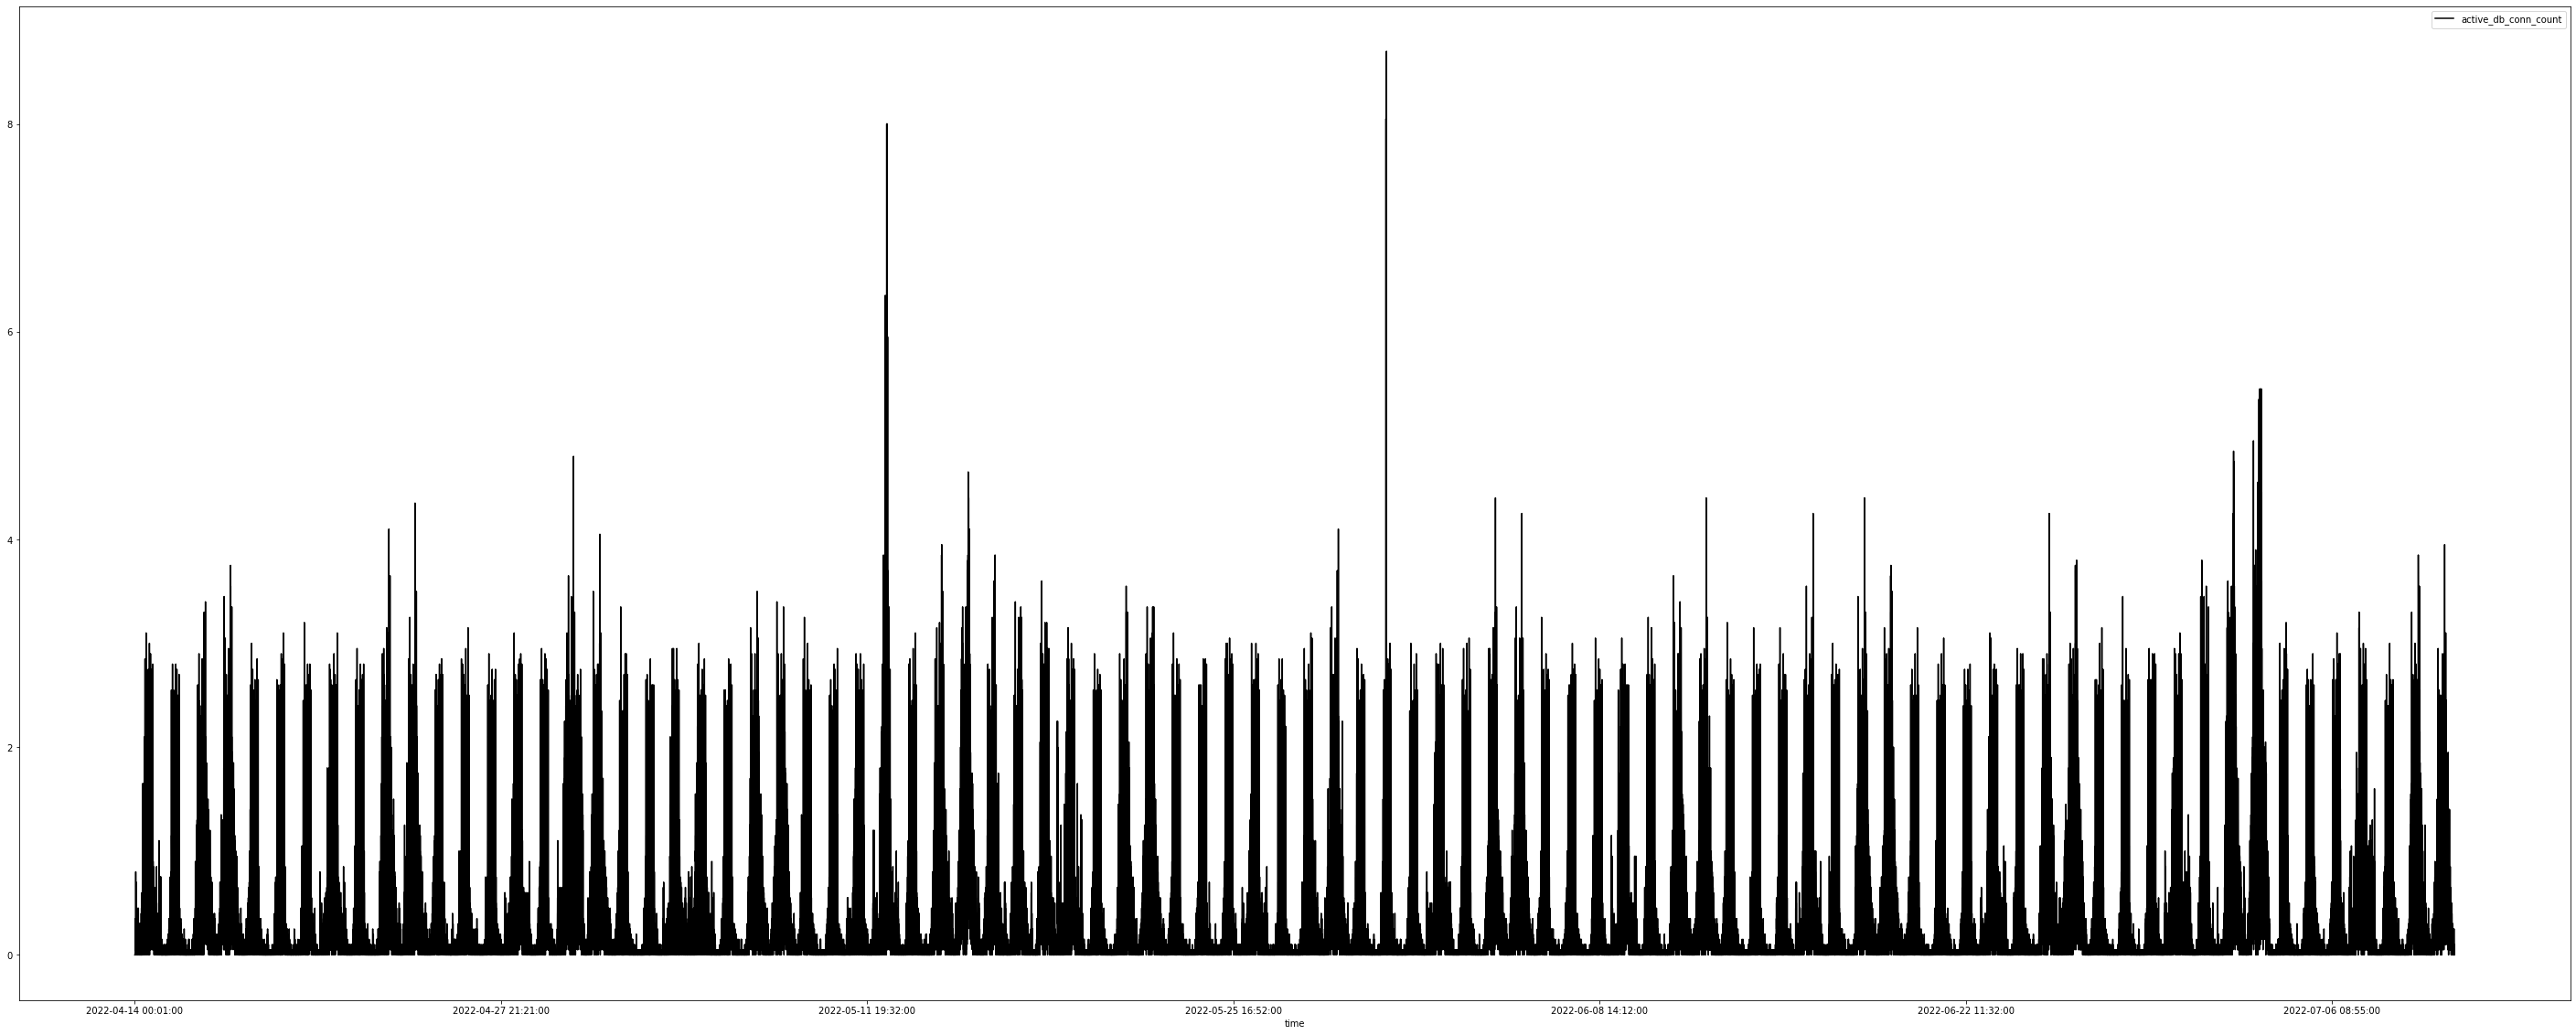

In [22]:
ax = plt.gca()
df[df['time'] > '2022-04-14 00:00:00'].plot(kind='line',x='time',y='active_db_conn_count', color='black', ax=ax, figsize=(50, 20))
plt.savefig('output.png')

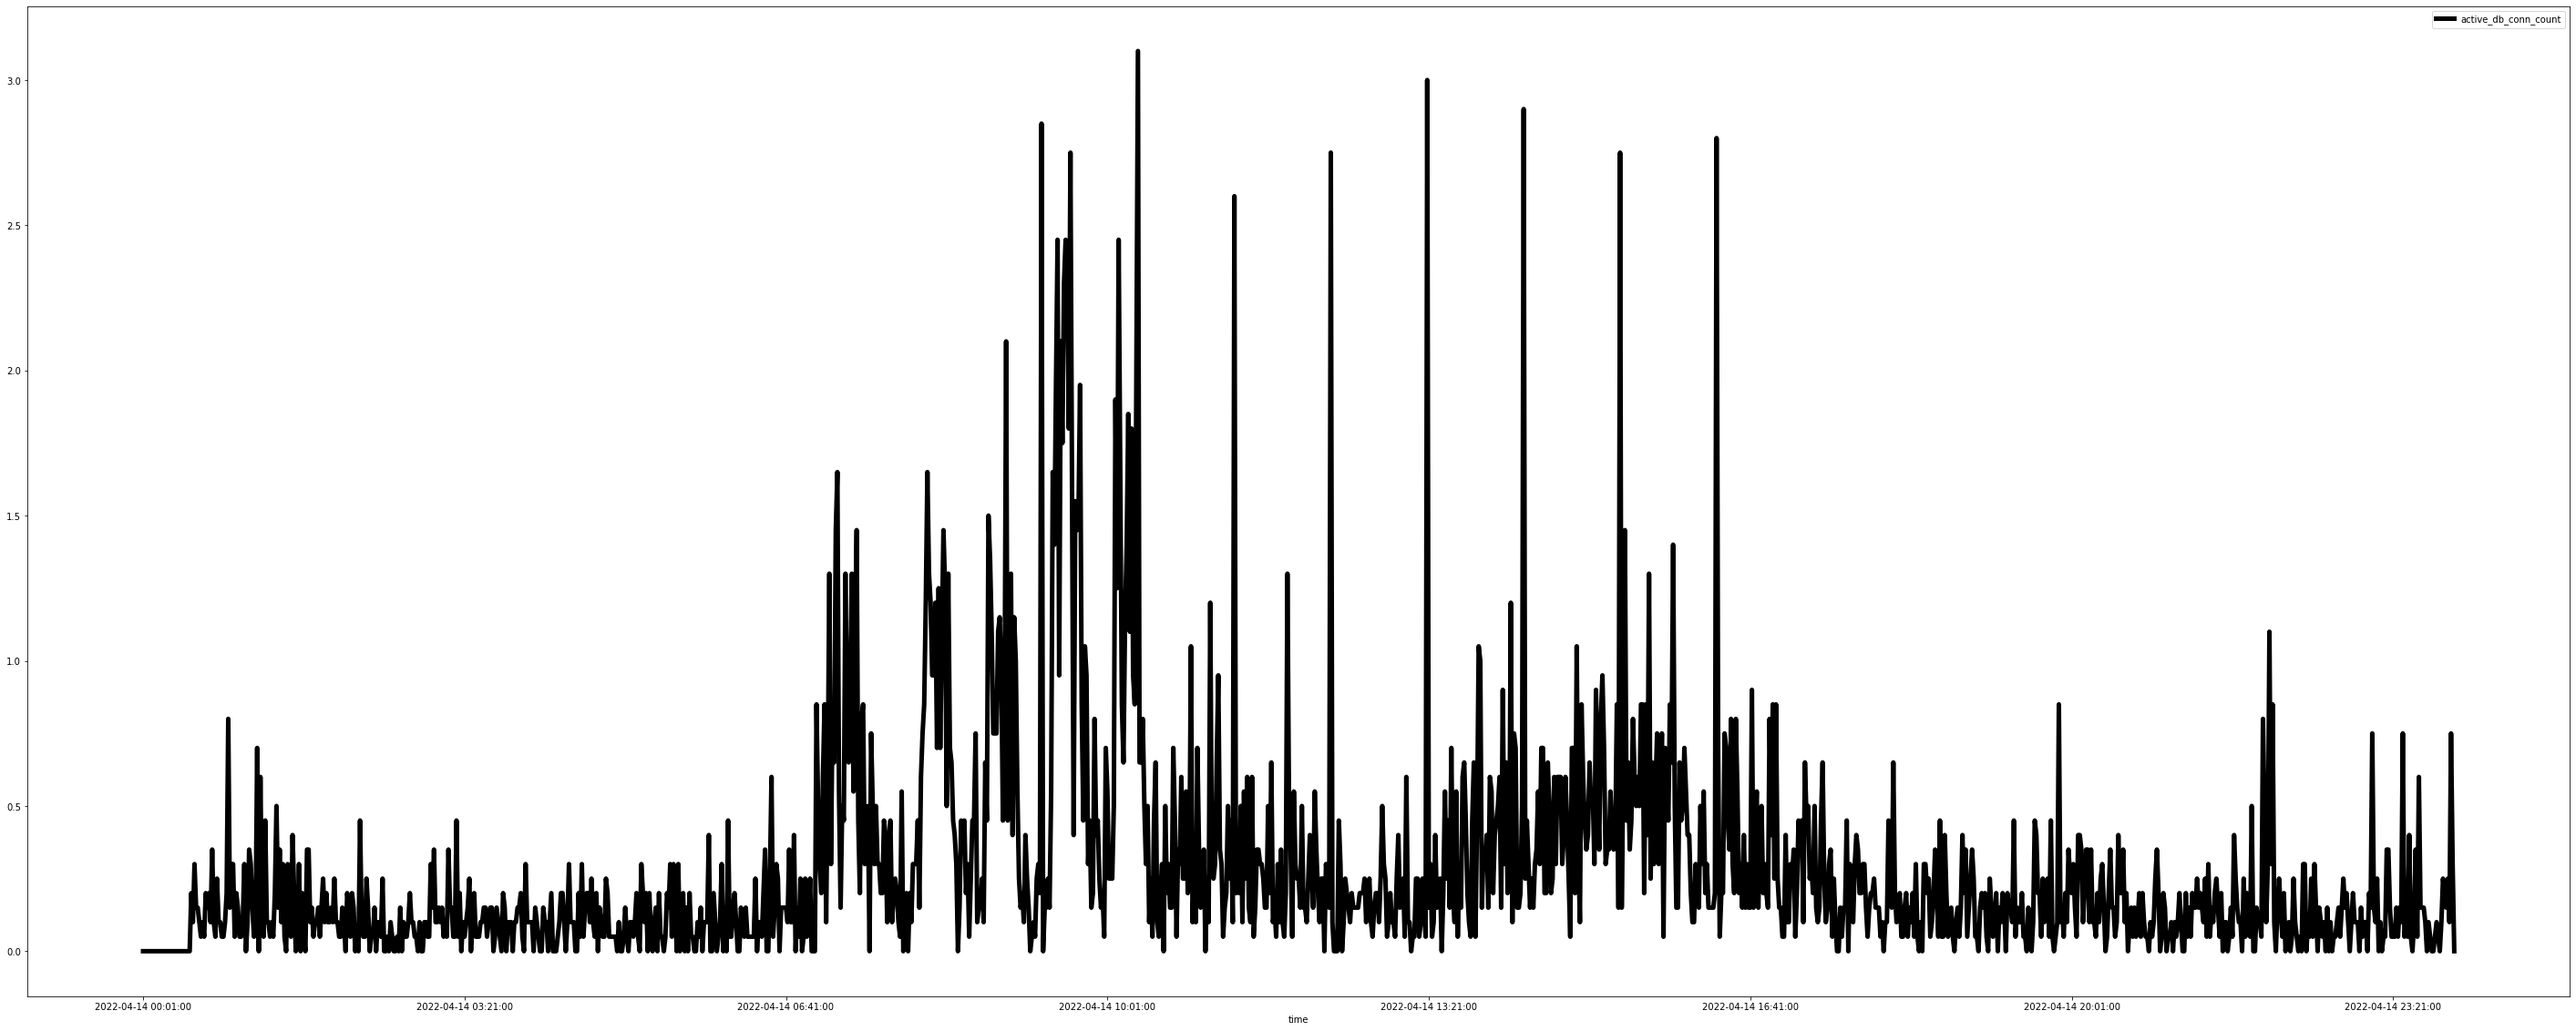

In [23]:
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-14 23:59:59')
df_ = df.loc[mask, :]

ax = plt.gca()
df_.plot(kind='line',x='time',y='active_db_conn_count', color='black', ax=ax, figsize=(50, 20), linewidth=5)
# plt.savefig('output.png')

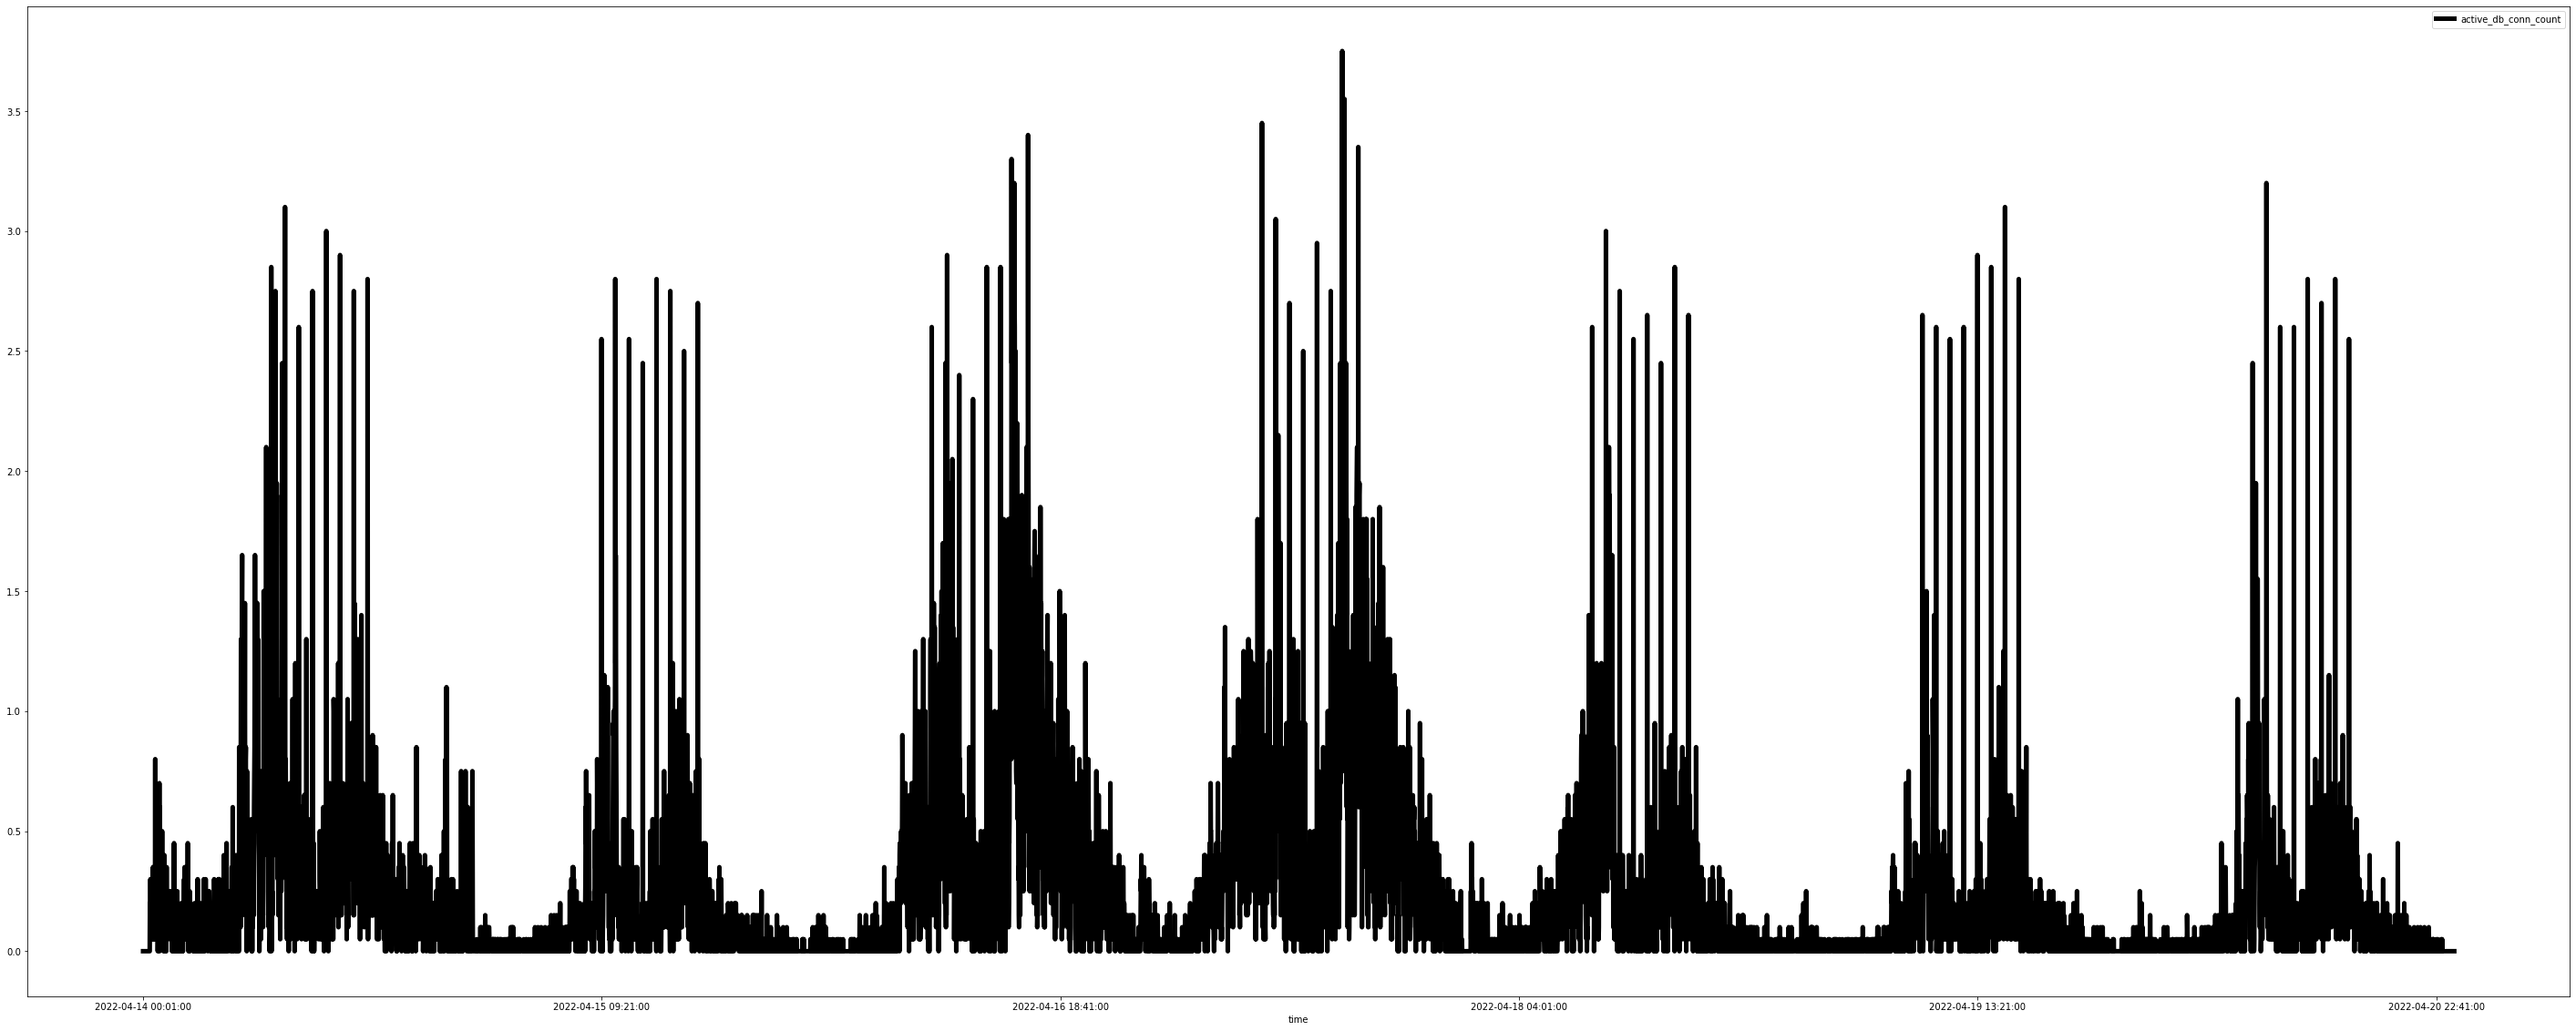

In [24]:
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]

ax = plt.gca()
df_.plot(kind='line',x='time',y='active_db_conn_count', color='black', ax=ax, figsize=(50, 20), linewidth=5)


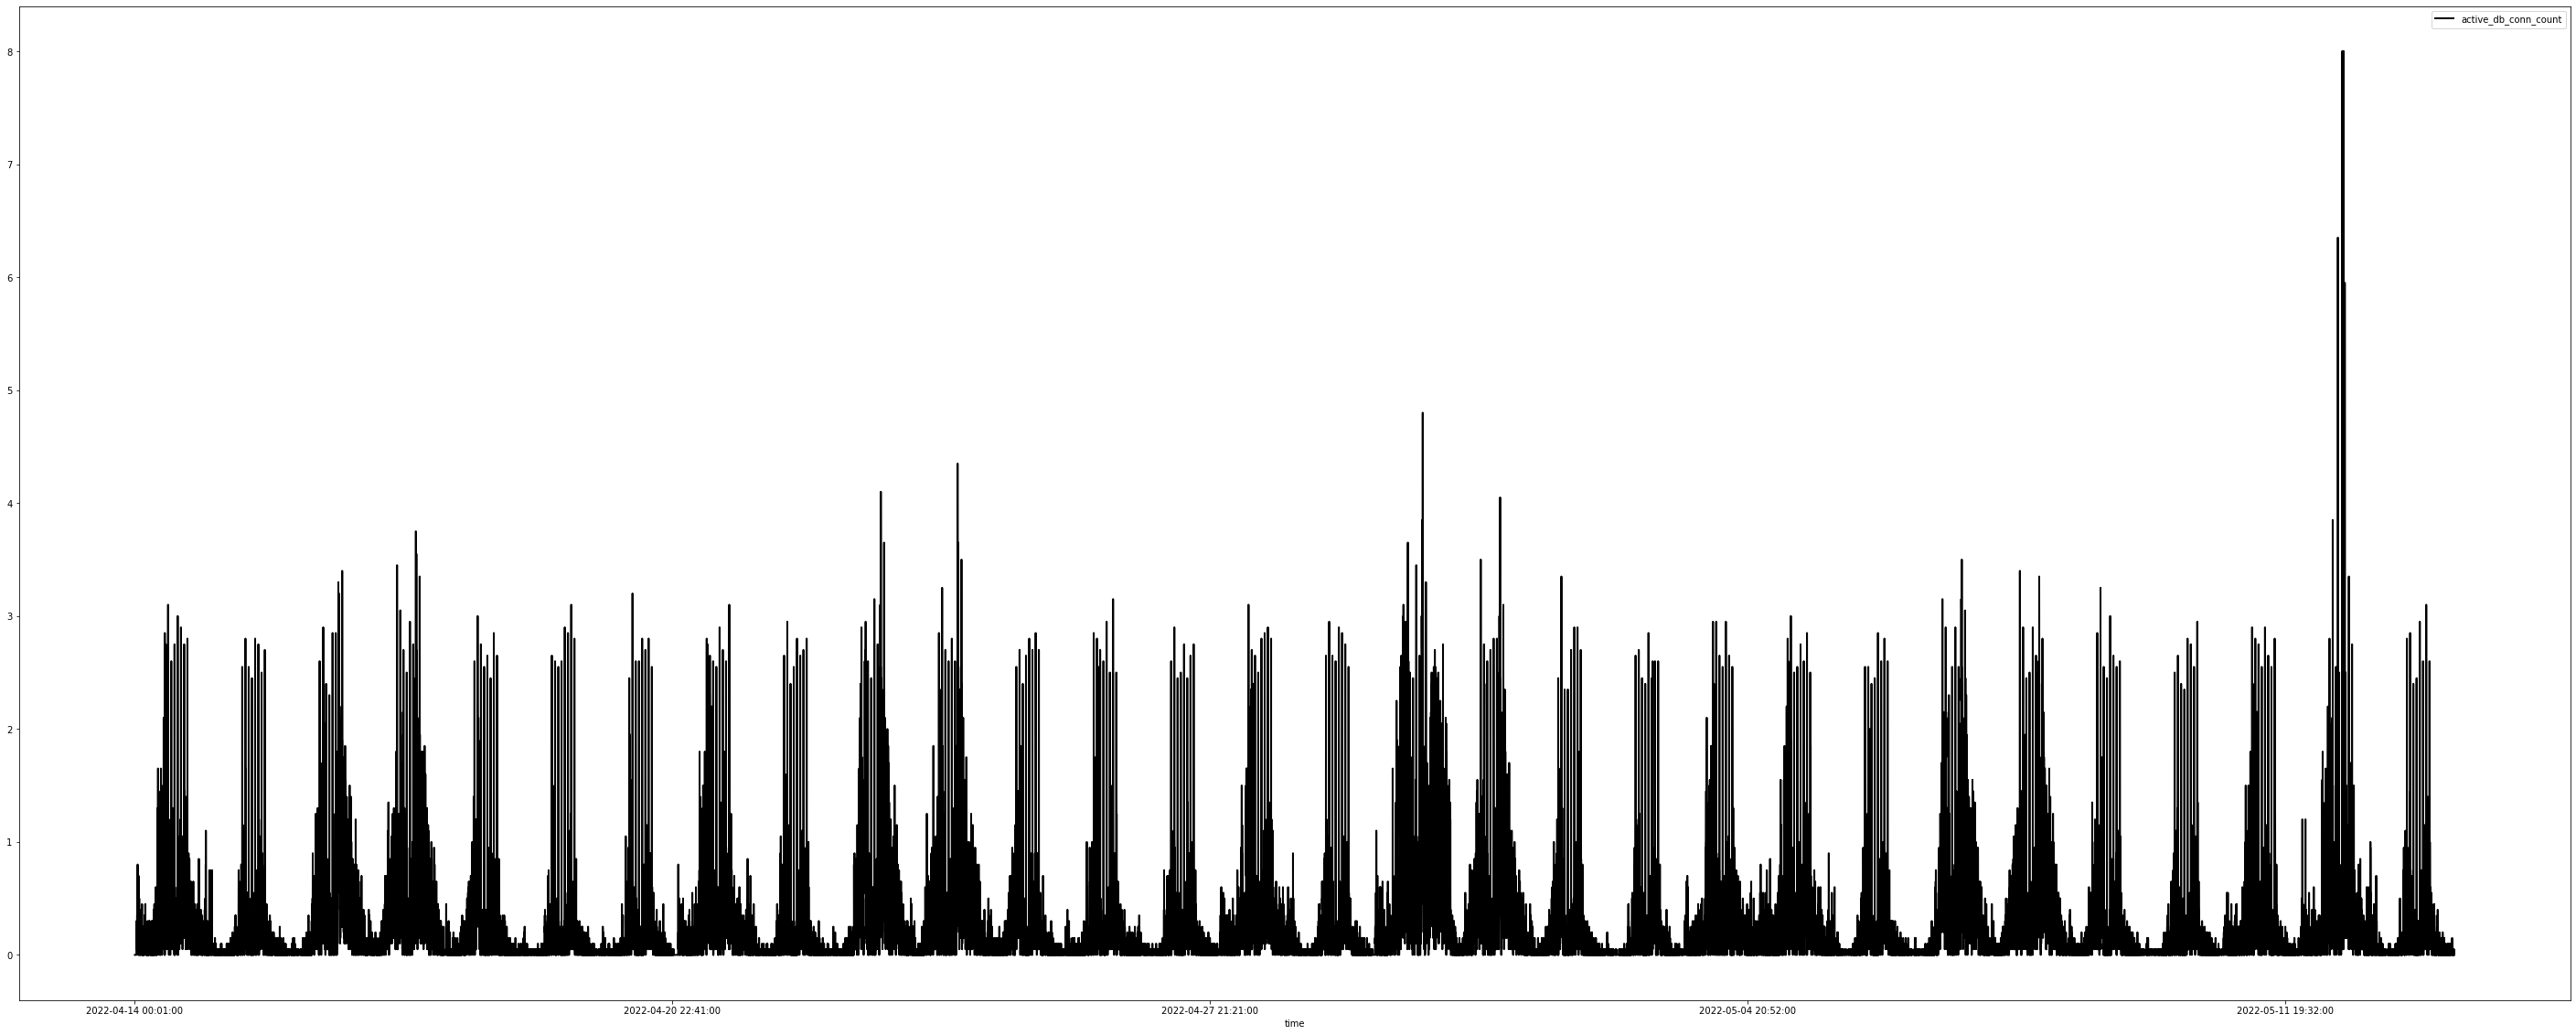

In [25]:
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-05-13 23:59:59')
df_ = df.loc[mask, :]

ax = plt.gca()
df_.plot(kind='line',x='time',y='active_db_conn_count', color='black', ax=ax, figsize=(50, 20), linewidth=2)


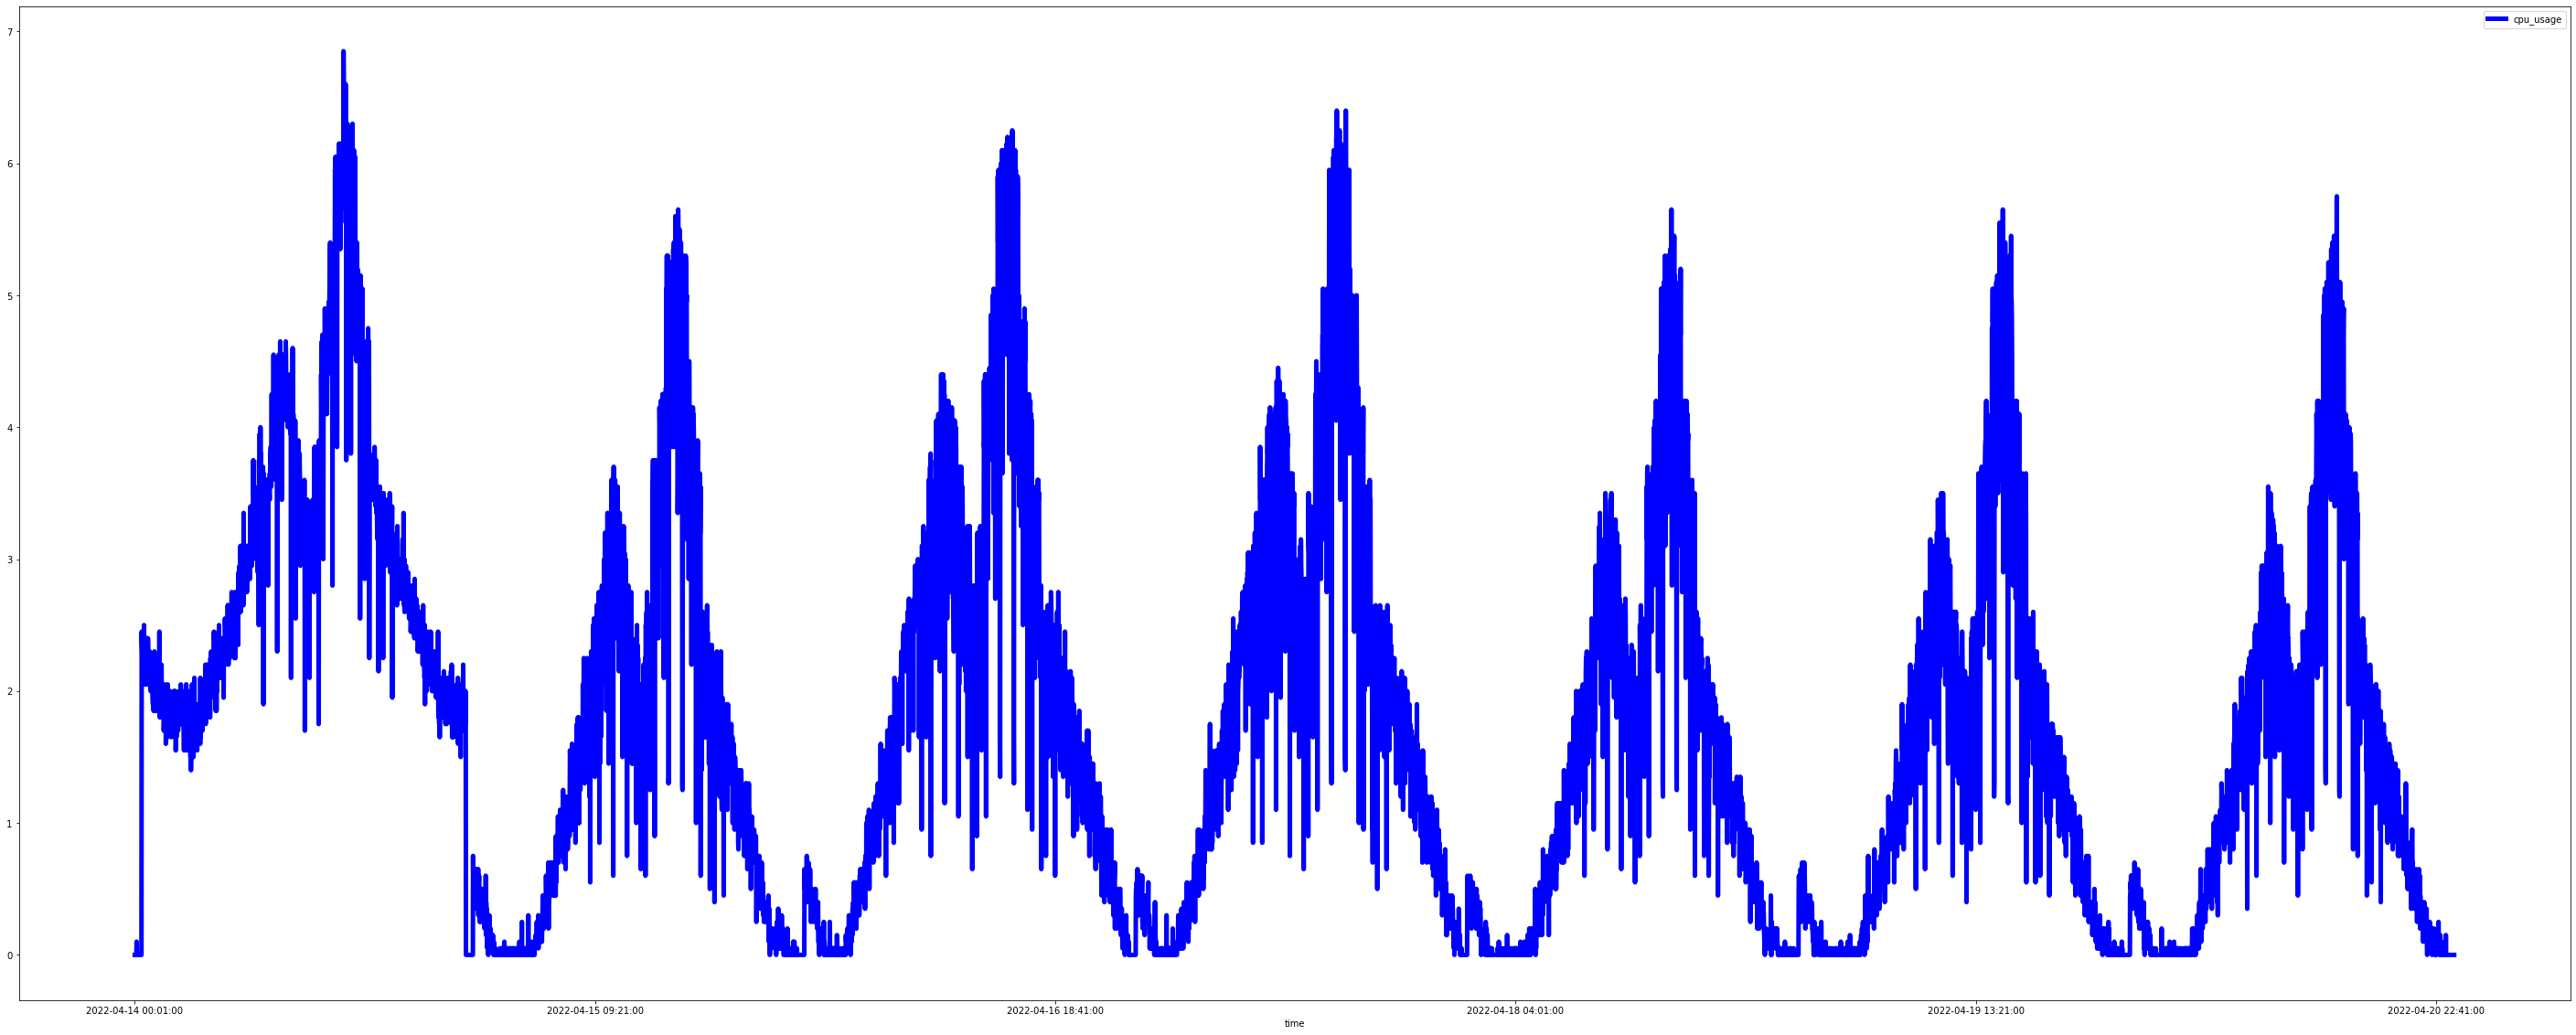

In [26]:
# cpu_usage line graph - 7days
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]

ax = plt.gca()
df_.plot(kind='line',x='time',y='cpu_usage', color='blue', ax=ax, figsize=(50, 20), linewidth=5)

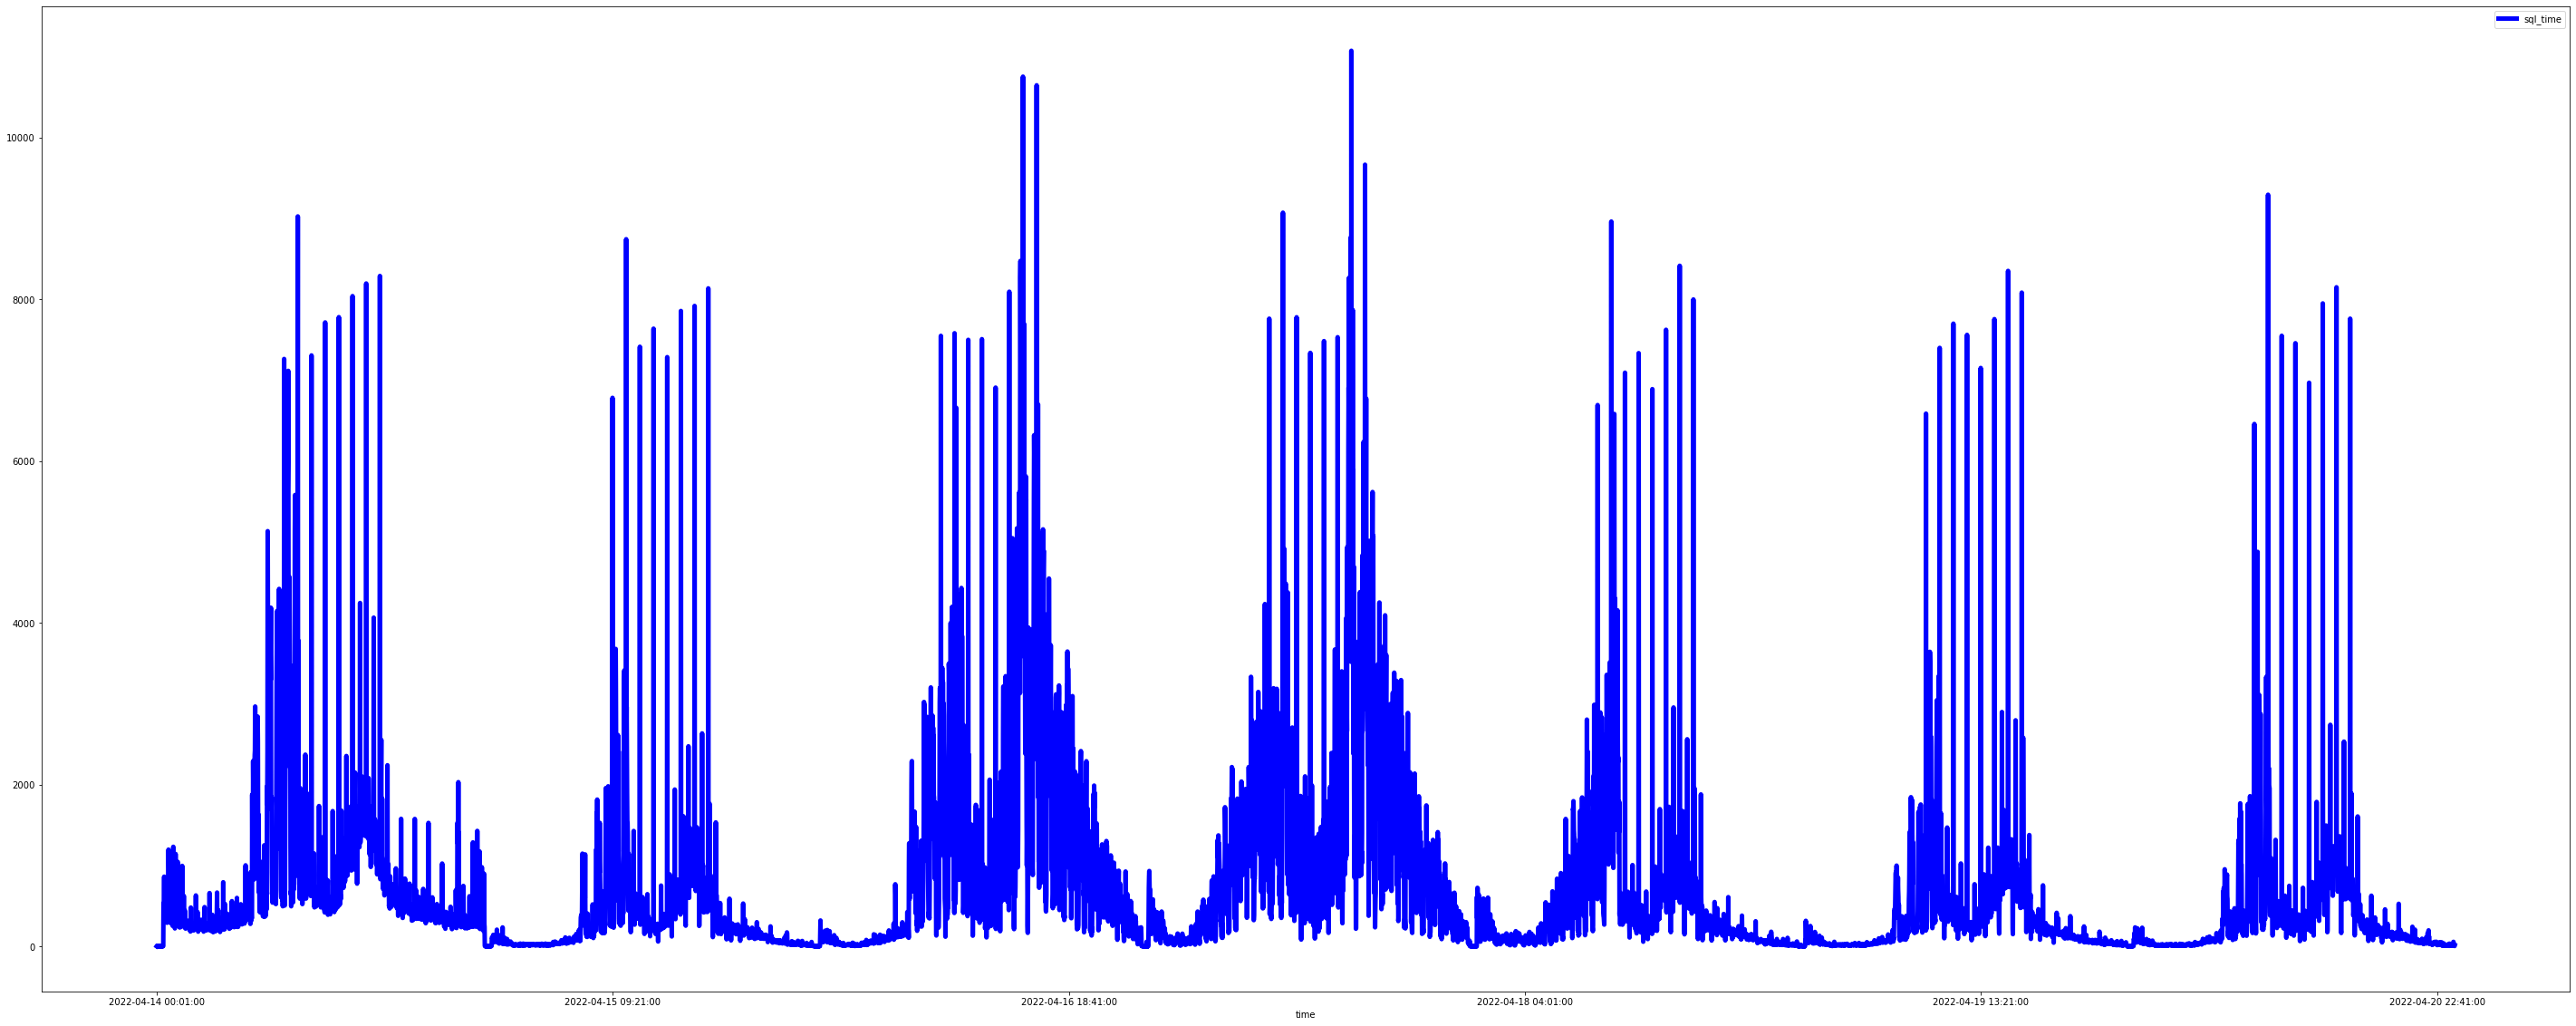

In [27]:
# sql_time line graph - 7days
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]

ax = plt.gca()
df_.plot(kind='line',x='time',y='sql_time', color='blue', ax=ax, figsize=(50, 20), linewidth=5)

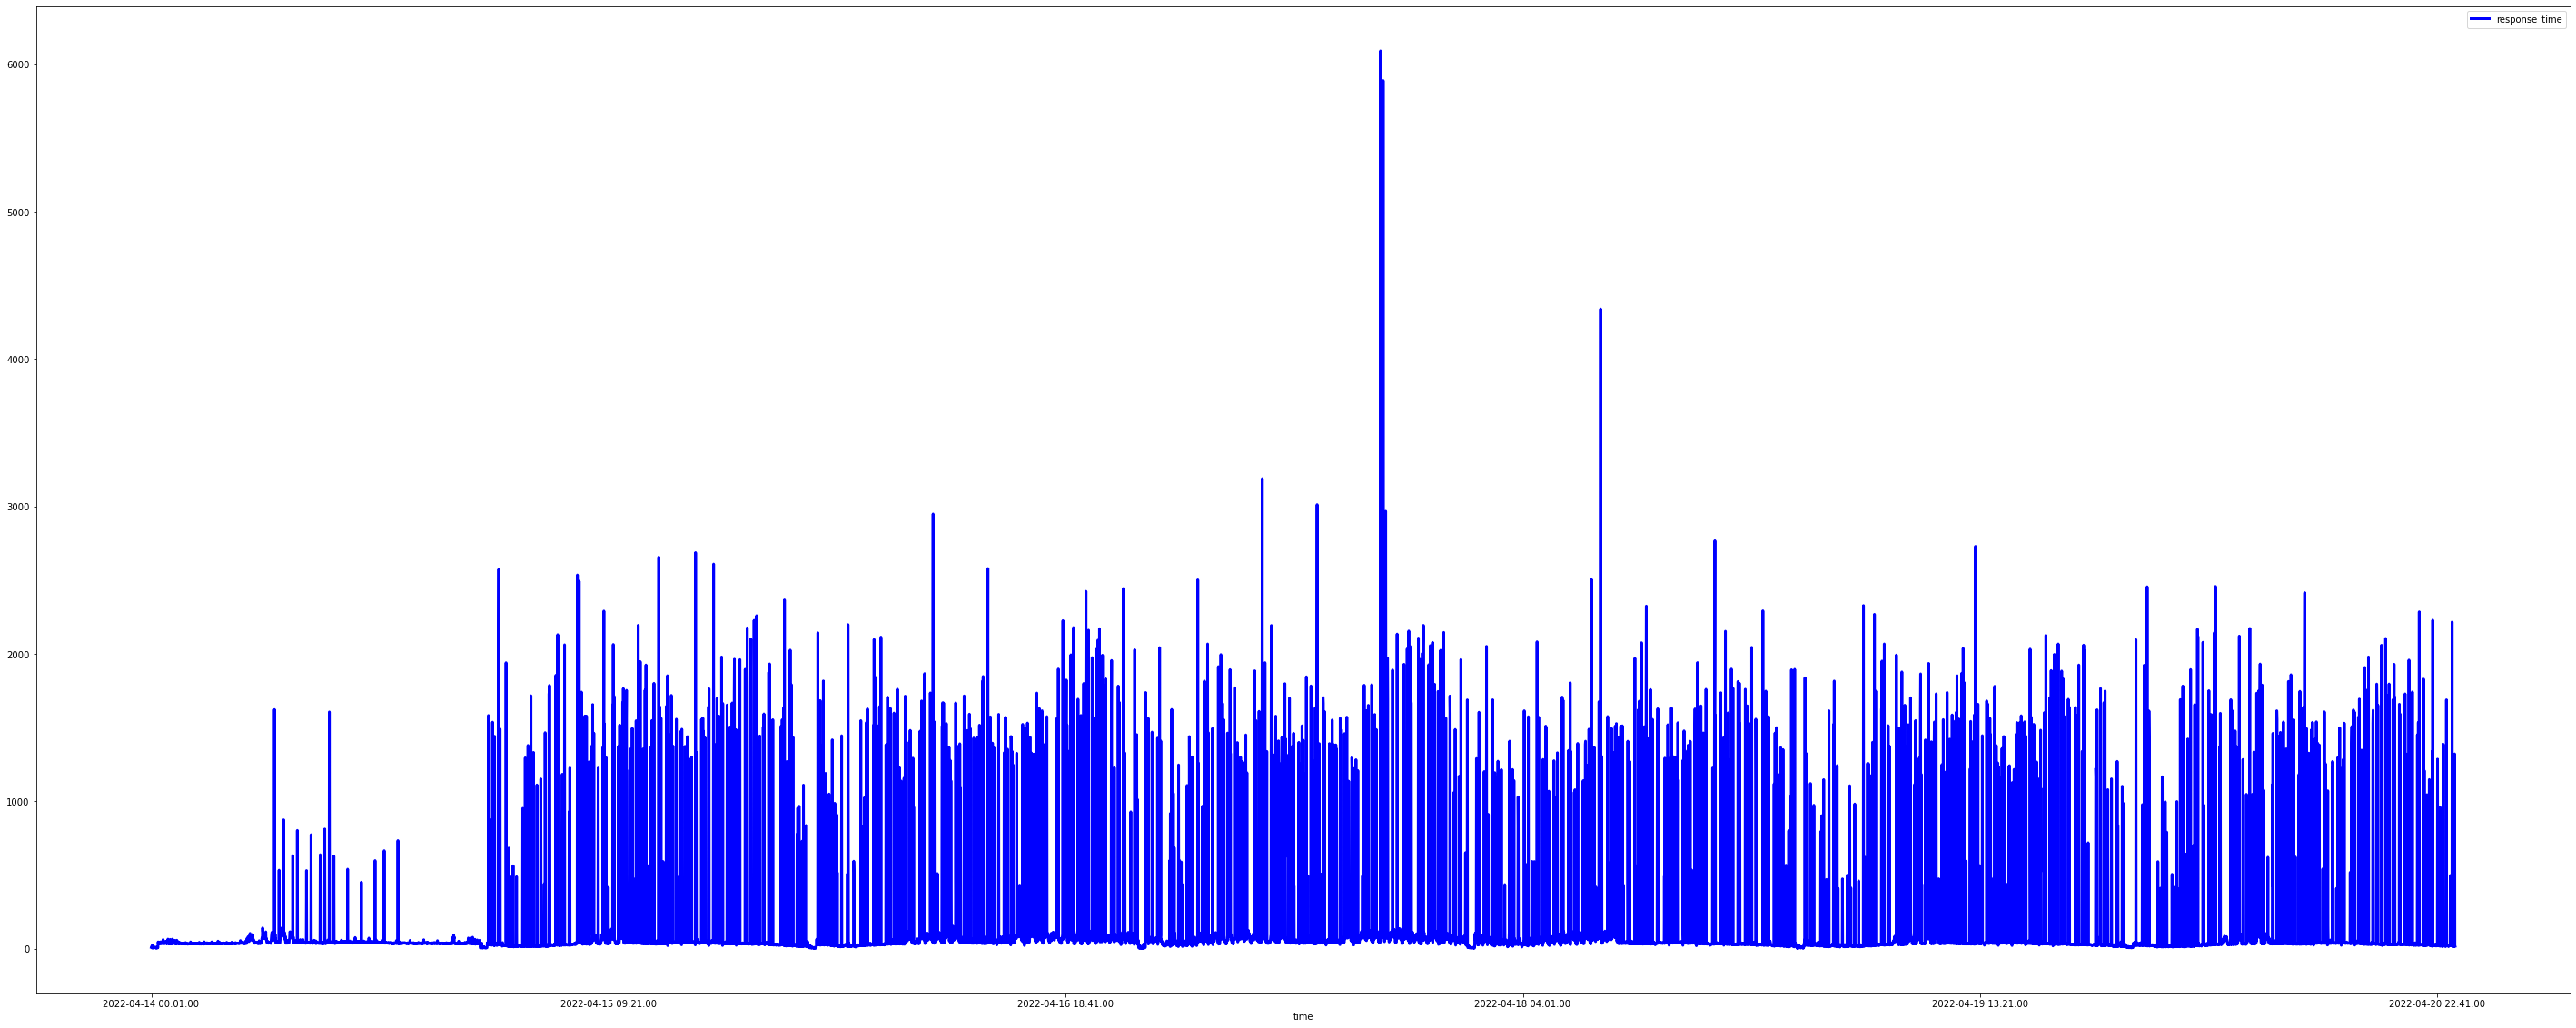

In [28]:
# response_time line graph - 7days
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]

ax = plt.gca()
df_.plot(kind='line',x='time',y='response_time', color='blue', ax=ax, figsize=(50, 20), linewidth=3)

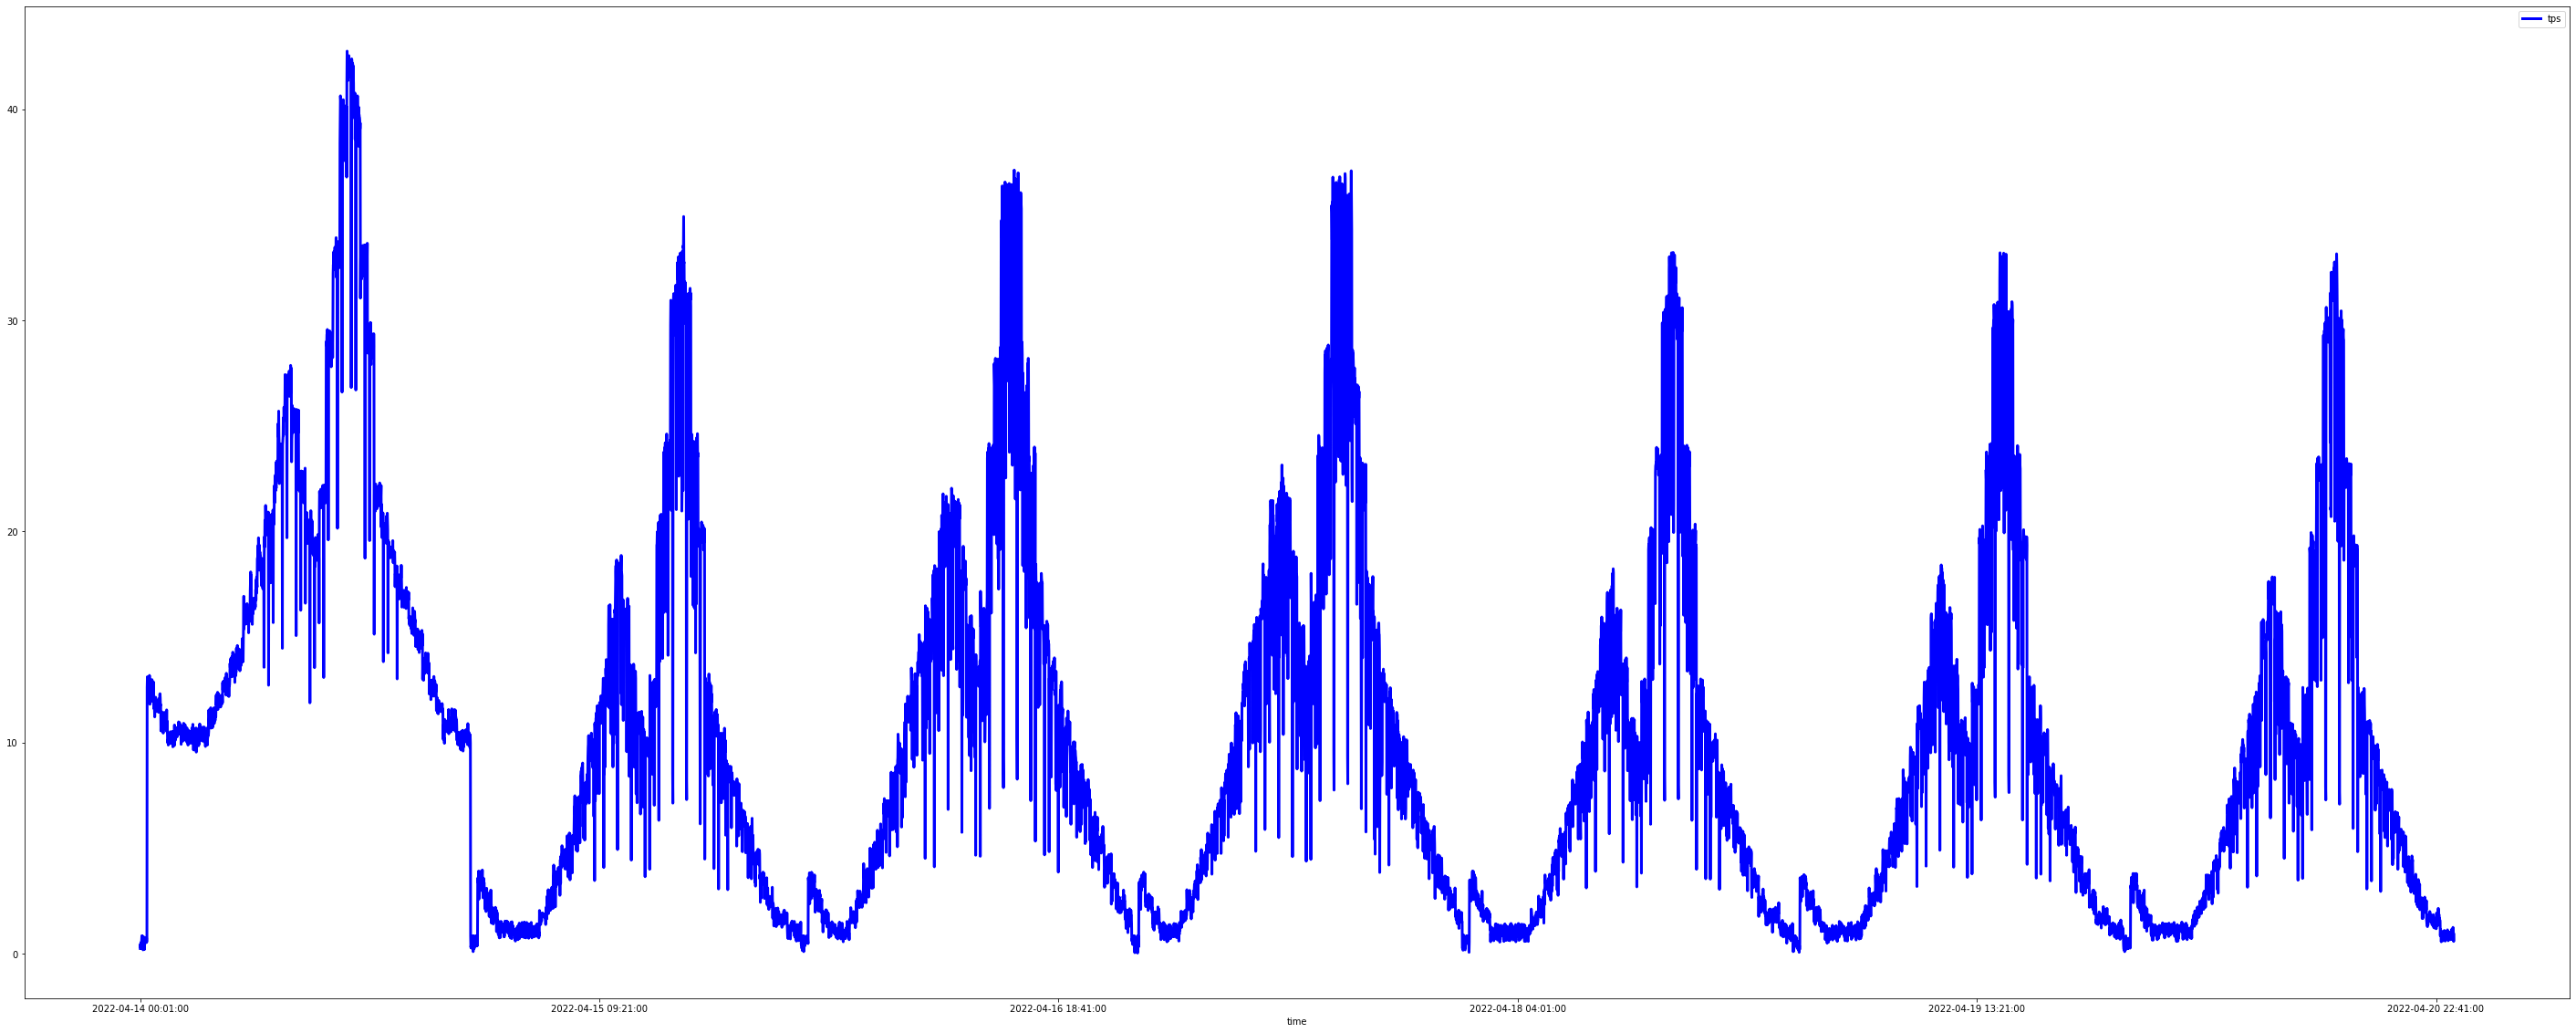

In [29]:
# tps line graph - 7days
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]

ax = plt.gca()
df_.plot(kind='line',x='time',y='tps', color='blue', ax=ax, figsize=(50, 20), linewidth=3)

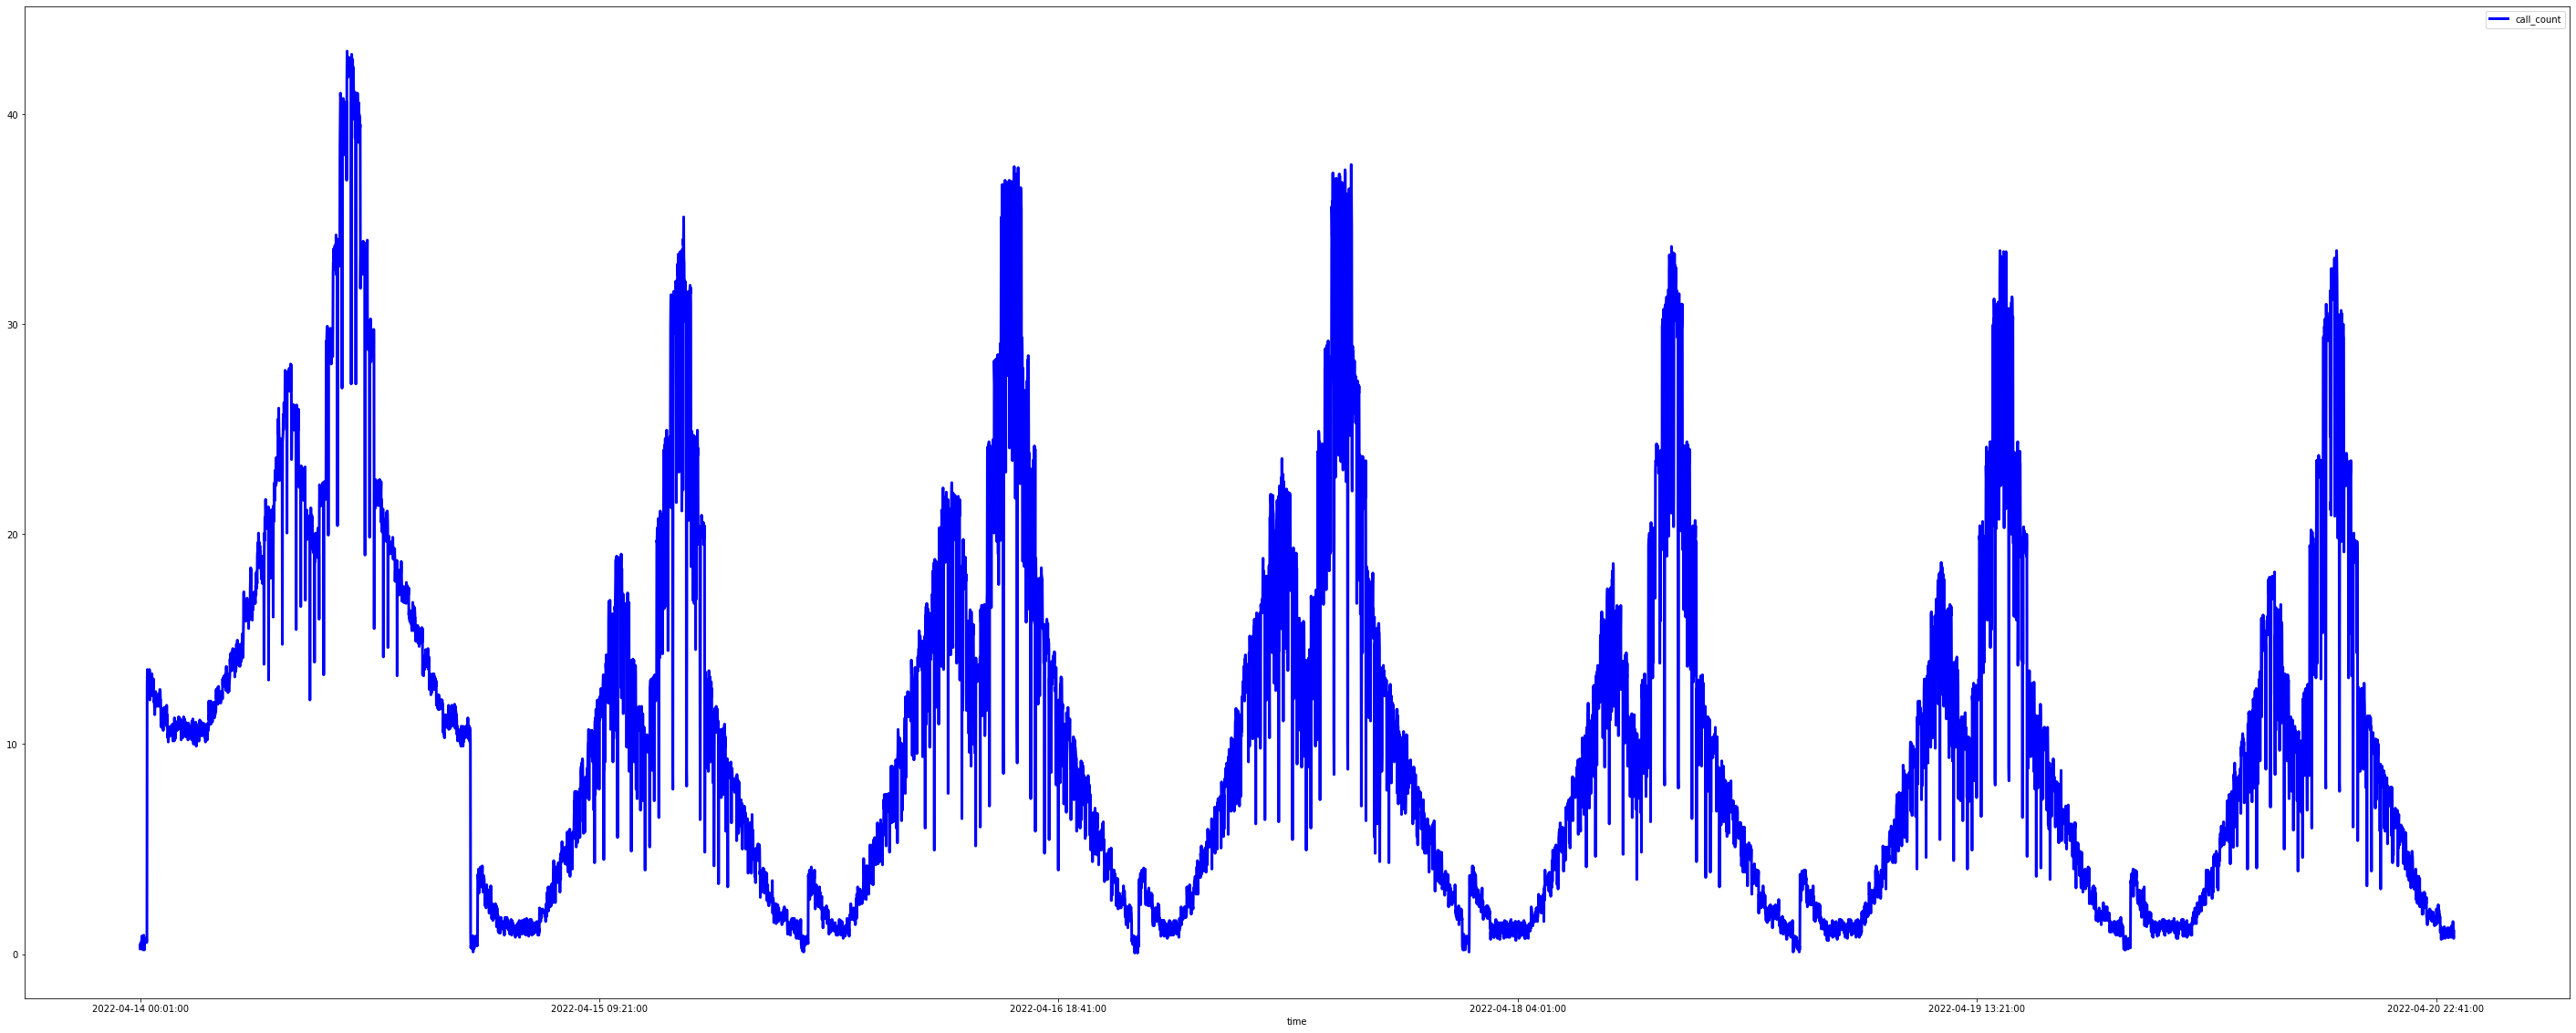

In [30]:
# call_count line graph - 7days
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]

ax = plt.gca()
df_.plot(kind='line',x='time',y='call_count', color='blue', ax=ax, figsize=(50, 20), linewidth=3)

In [31]:
df_.describe().to_csv('df_desc.csv')

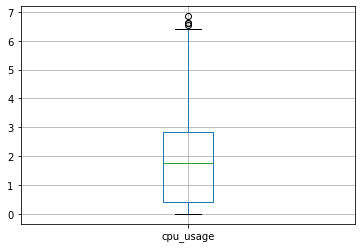

In [32]:
some_columns = ['cpu_usage']
df_.boxplot(column=some_columns)


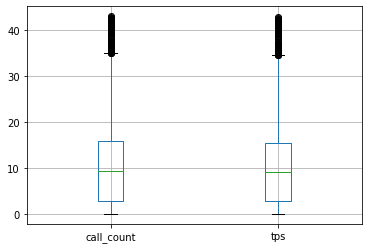

In [33]:
some_columns = ['call_count', 'tps']
df_.boxplot(column=some_columns)

In [34]:
# some feature's statistical values
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]
df_

some_columns = ['time', 'active_db_conn_count', 'active_tx_count', 'call_count', 'cpu_time', 'cpu_usage', 'db_sessions', 'response_time', 'sql_count', 'tps']
df__ = df_[some_columns]
df__.describe().to_csv('some_features_static_values.csv')


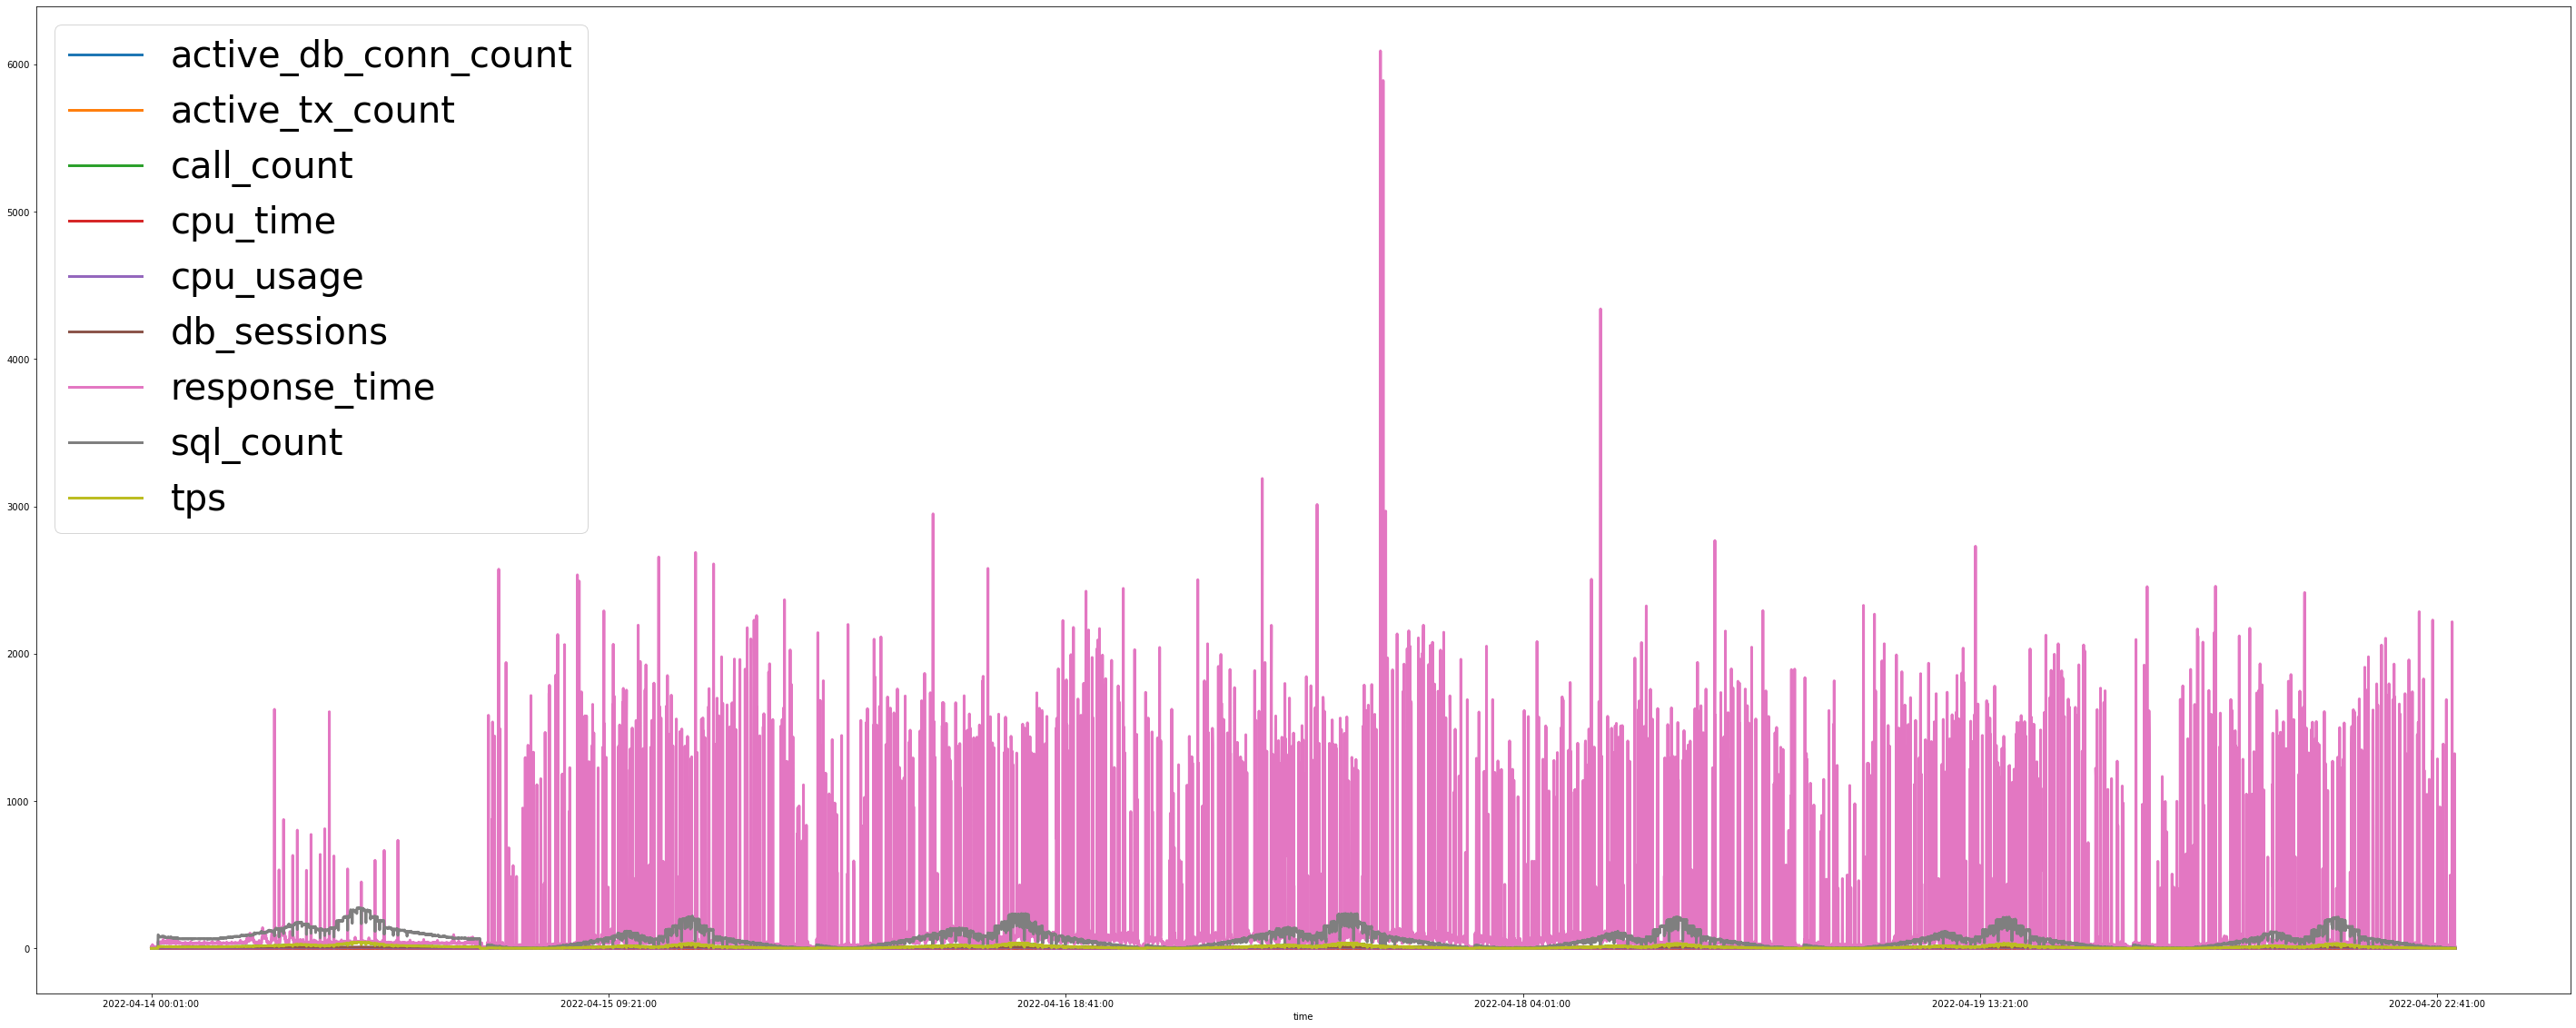

In [35]:
# line plot some features without scaling
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]
df_

some_columns = ['time', 'active_db_conn_count', 'active_tx_count', 'call_count', 'cpu_time', 'cpu_usage', 'db_sessions', 'response_time', 'sql_count', 'tps']
df__ = df_[some_columns]

ax = plt.gca()
ax1 = df__.plot(kind='line',x='time', ax=ax, figsize=(50, 20), linewidth=3, logy=False)
ax1.legend(loc=2,fontsize=40)

# df__.describe()
# df__.describe().to_csv('some_features_static_values.csv')


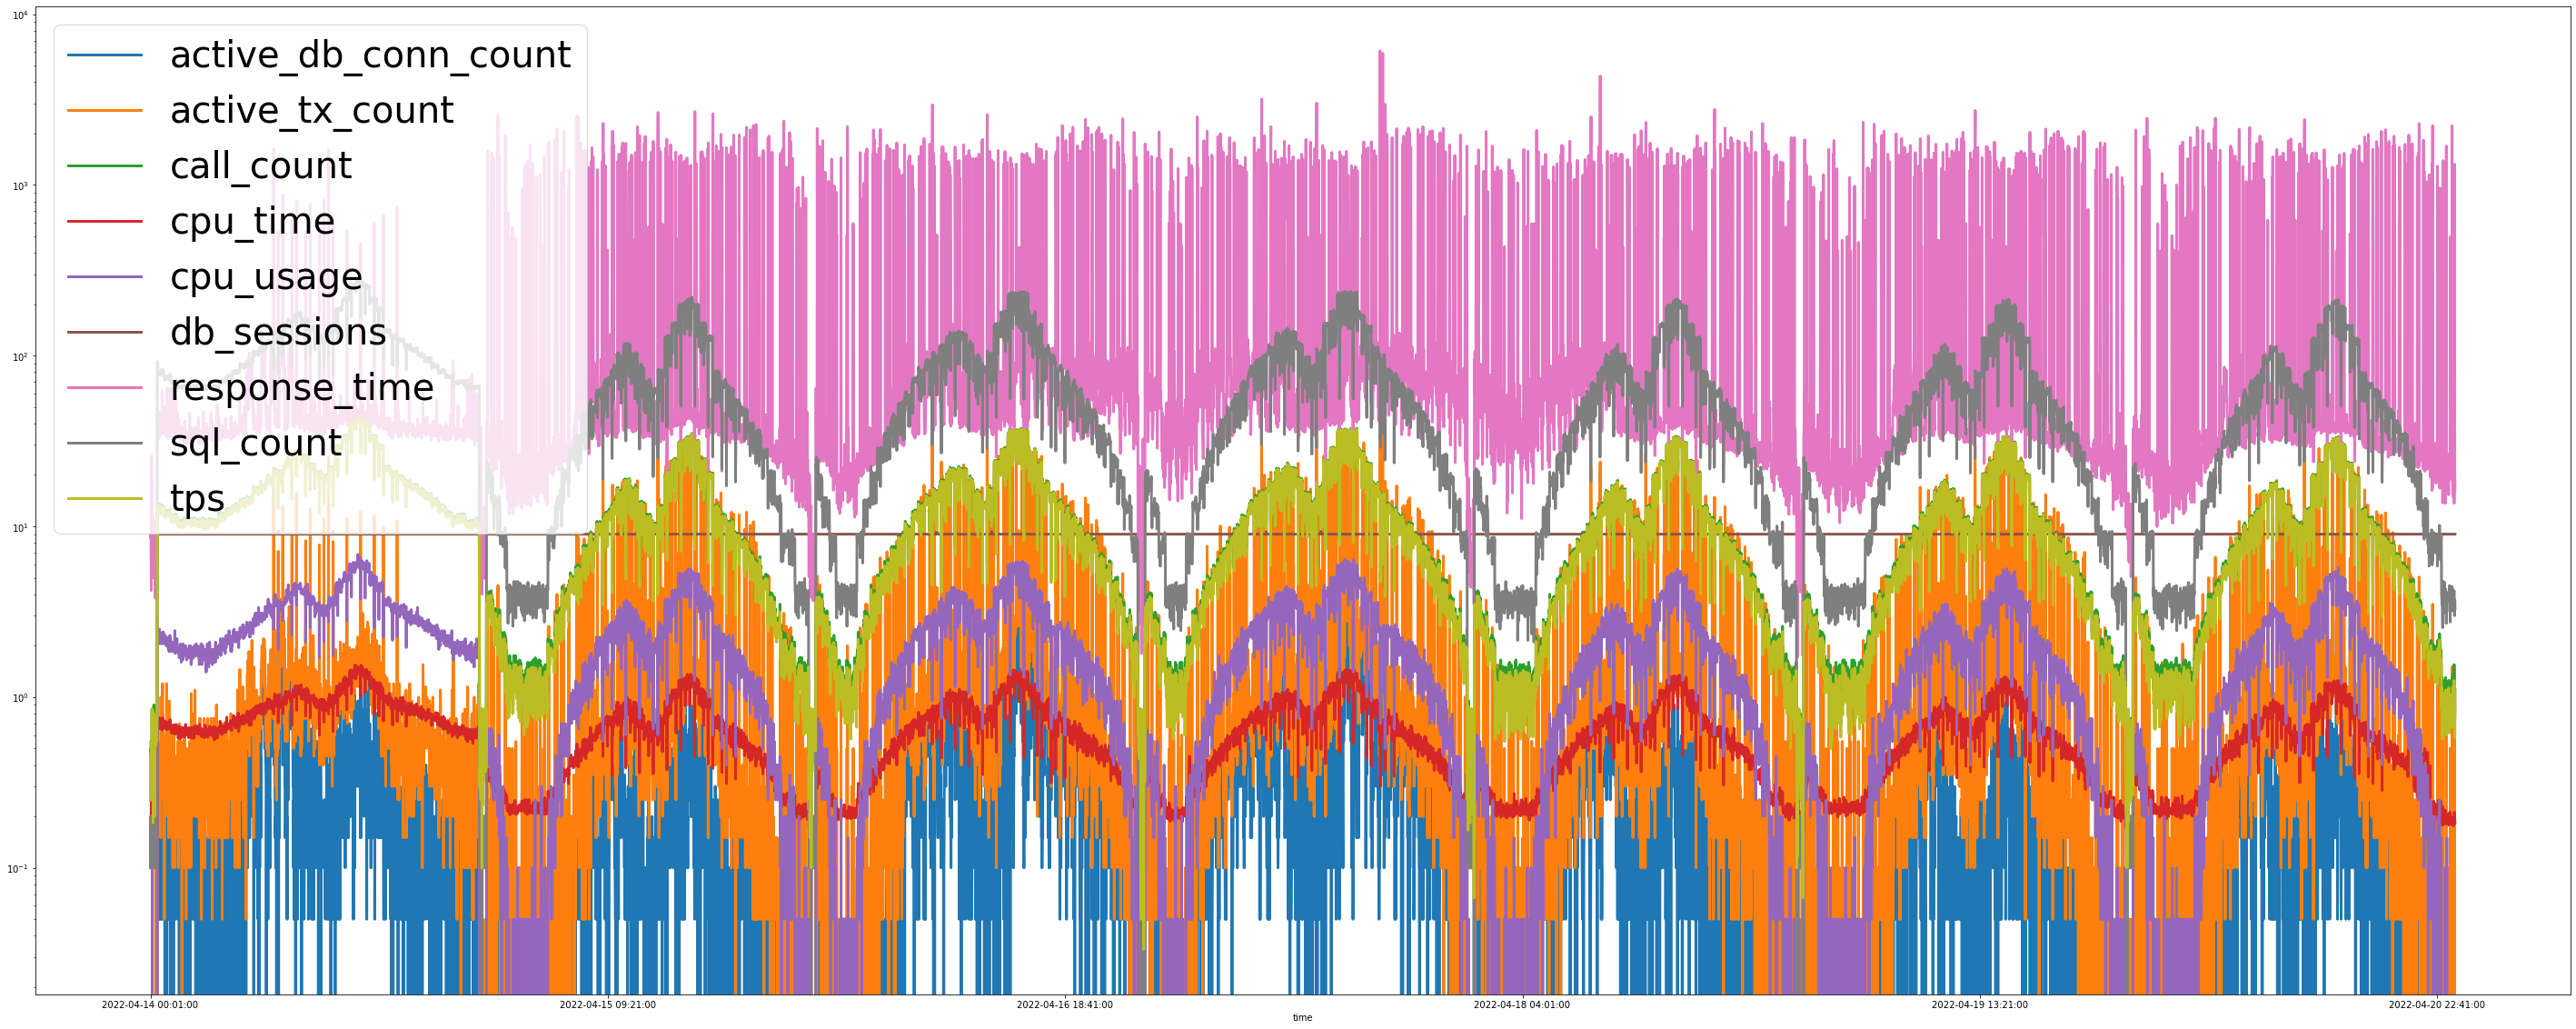

In [36]:
# line plot some features with log scaling
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]
df_

some_columns = ['time', 'active_db_conn_count', 'active_tx_count', 'call_count', 'cpu_time', 'cpu_usage', 'db_sessions', 'response_time', 'sql_count', 'tps']
df__ = df_[some_columns]

ax = plt.gca()
ax1 = df__.plot(kind='line',x='time', ax=ax, figsize=(50, 20), linewidth=3, logy=True)
ax1.legend(loc=2,fontsize=40)

# df__.describe()
# df__.describe().to_csv('some_features_static_values.csv')


['active_db_conn_count', 'active_tx_count', 'call_count', 'cpu_time', 'cpu_usage', 'db_sessions', 'response_time', 'sql_count', 'tps']


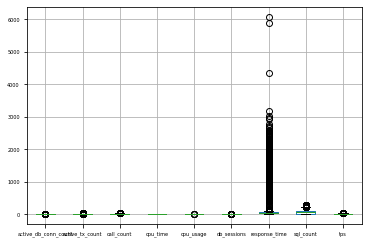

In [37]:
# box plot some features without log scale
if 'time' in some_columns:
    some_columns_ = some_columns.remove('time')
print(some_columns)
    
df__.boxplot(column=some_columns, fontsize=5)

['active_db_conn_count', 'active_tx_count', 'call_count', 'cpu_time', 'cpu_usage', 'db_sessions', 'response_time', 'sql_count', 'tps']


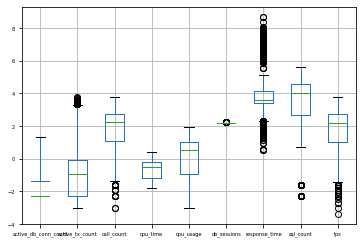

In [38]:
# box plot some features with log scale
if 'time' in some_columns:
    some_columns_ = some_columns.remove(['time'])
print(some_columns)
for column in some_columns:
    df__[column] = np.log(df__[column])
    
df__.boxplot(column=some_columns, fontsize=5)

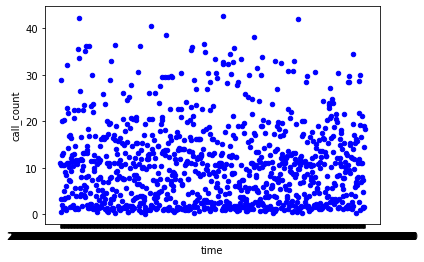

In [39]:
# scatter plot some features without log scaling
mask = (df['time'] > '2022-04-14 00:00:00') & (df['time'] < '2022-04-20 23:59:59')
df_ = df.loc[mask, :]
df_ = df_.sample(frac=0.1)

some_columns = ['time', 'active_db_conn_count', 'active_tx_count', 'call_count', 'cpu_time', 'cpu_usage', 'db_sessions', 'response_time', 'sql_count', 'tps']
df__ = df_[some_columns]

# ax = plt.gca()
some_columns.remove('time')

ax1 = df__.plot(kind='scatter', x='time', y='call_count', color='b')
# ax2 = df__.plot(kind='scatter', x='time', y='d', color='g', ax=ax1)    
# ax3 = df__.plot(kind='scatter', x='time', y='f', color='b', ax=ax1)

# ax1.legend(loc=2,fontsize=40)


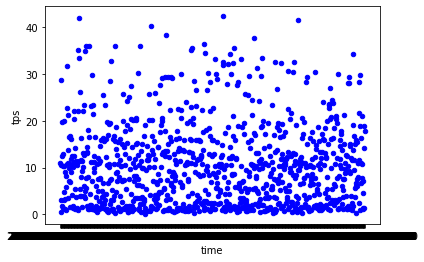

In [40]:
df__.plot(kind='scatter', x='time', y='tps', color='b')

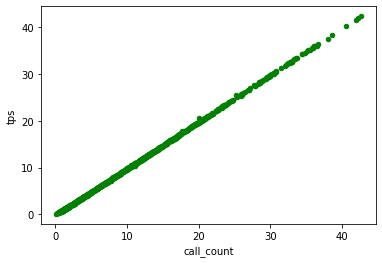

In [41]:
df__.plot(kind='scatter', x='call_count', y='tps', color='g')

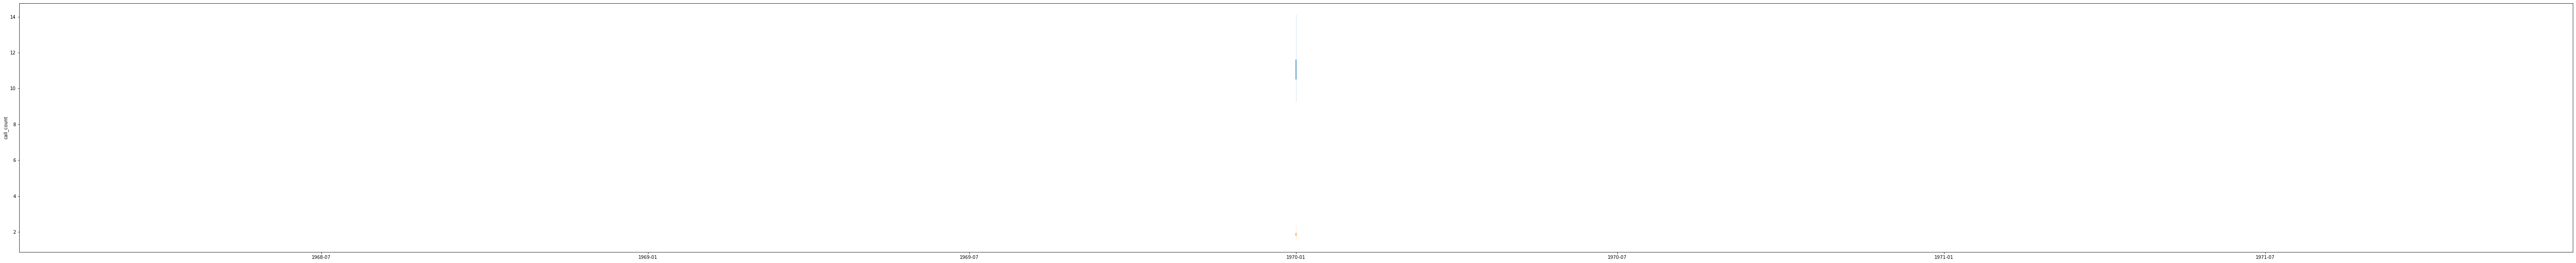

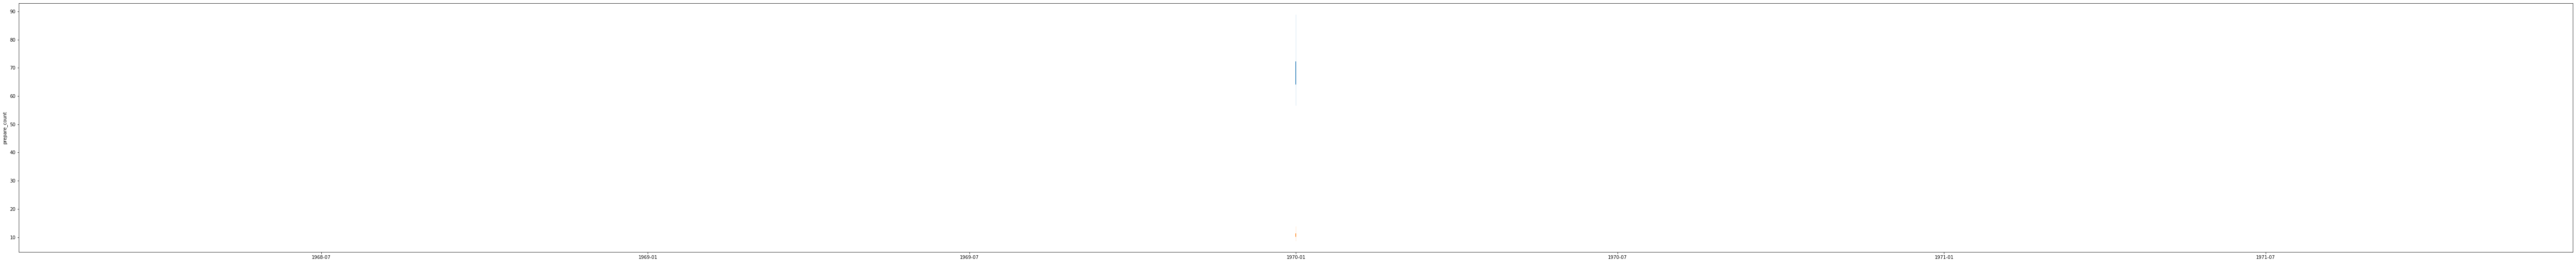

In [42]:
## draw lineplot with high corr time series data
time = pd.to_datetime(df__.index)
df__.index

# call_count, cpu_usage
plt.figure(figsize=(100,10))
sns.lineplot(data=df_['call_count'], x=time, y=df_['call_count'])
sns.lineplot(data=df_['cpu_usage'], x=time, y=df_['cpu_usage'])
# plt.legend(['call_count', 'cpu_usage'], fontsize=20)

# prepare_count, tps
plt.figure(figsize=(100,10))
sns.lineplot(data=df_['prepare_count'], x=time, y=df_['prepare_count'])
sns.lineplot(data=df_['tps'], x=time, y=df_['tps'])

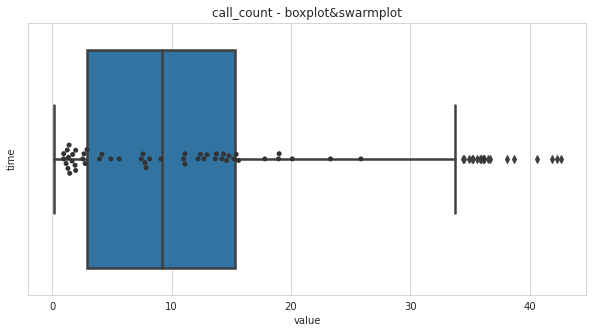

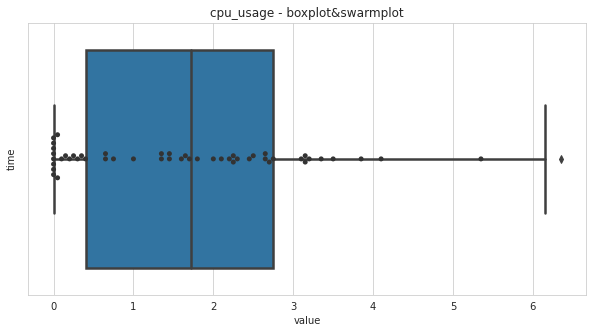

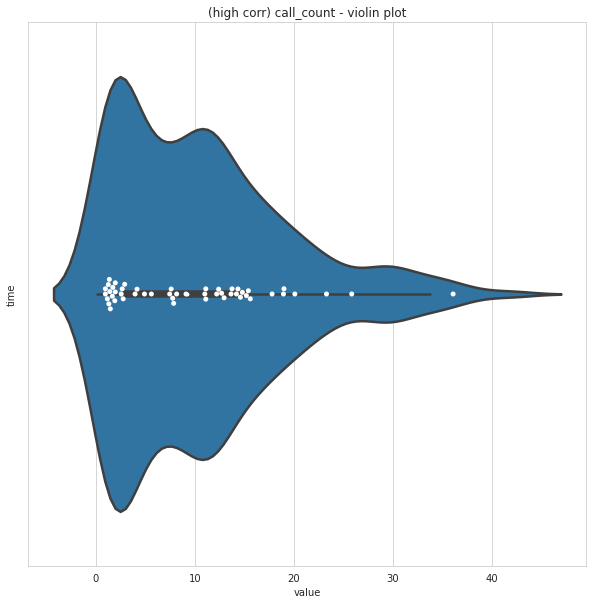

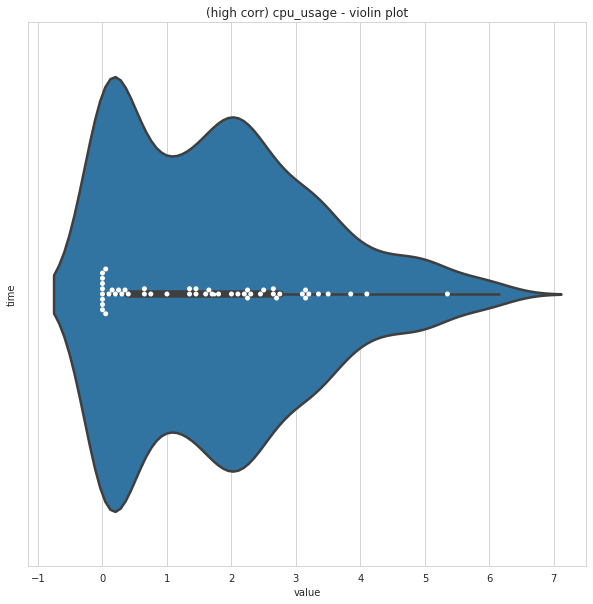

In [43]:
## show two metrics having high corr
columns_high_corr = ['call_count', 'cpu_usage']
sns.set_style("whitegrid")

# boxplot&swarmplot
for column in columns_high_corr:
    plt.figure(figsize=(10,5))
    
    box_plot = sns.boxplot(data=df_, x=column, linewidth=2.5)
    box_plot.set(title=f'{column} - boxplot&swarmplot')
    box_plot.set(xlabel='value')
    box_plot.set(ylabel='time')

    swarm_plot = sns.swarmplot(data=df_.sample(frac=0.05, axis=0, random_state=1), x=column, color=".2", edgecolor="gray")
    swarm_plot.set(xlabel='value')
    swarm_plot.set(ylabel='time')

# violinplot
for column in columns_high_corr:
    plt.figure(figsize=(10,10))
    
    box_plot = sns.violinplot(data=df_, x=column, linewidth=2.5)
    box_plot.set(title=f'(high corr) {column} - violin plot')

    swarm_plot = sns.swarmplot(data=df_.sample(frac=0.05, axis=0, random_state=1), x=column, color="white", edgecolor="gray")
    swarm_plot.set(xlabel='value')
    swarm_plot.set(ylabel='time')
    